In [274]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from analysis_utils import *
from constants import *
from nlp_synt_data import *
import numpy as np

In [275]:
df_stats = DF_STATS_GENDER.copy()
df_stats_melt = pd.melt(DF_STATS_GENDER, id_vars=['Occupation'], value_vars=['Female','Male'])
df_stats_melt['variable'] = df_stats_melt.apply(lambda x: x['variable'].lower(), axis=1)
df_stats_melt = df_stats_melt.sort_values('value', ascending=False)
df_stats_melt

,Occupation,variable,value
173,plasterer,male,0.991556
120,millwright,male,0.991041
191,mason,male,0.989986
190,plumber,male,0.984106
183,carpenter,male,0.981159
...,...,...,...
80,carpenter,female,0.018841
87,plumber,female,0.015894
88,mason,female,0.010014
17,millwright,female,0.008959


In [276]:
def make_bias_df(all=False):
    df_pred = pd.read_csv('llama_results.csv')
    df_pred['response'] = df_pred.apply(lambda x: str(x['response']).lower(), axis=1)
    df_pred = normalize_labels(fix_responses(df_pred))
    if not all:
        df_pred = df_pred.groupby(['text_JOB_value', 'prompt_id', 'response']).size().reset_index(name='proportion')
    else:
        df_pred = df_pred.groupby(['text_JOB_value', 'response']).size().reset_index(name='proportion')
    def _make_value(x):
        if not all:
            rows = df_pred[(df_pred['text_JOB_value'] == x['text_JOB_value']) & (df_pred['prompt_id'] == x['prompt_id'])]
        else:
            rows = df_pred[df_pred['text_JOB_value'] == x['text_JOB_value']]
        sum_values = rows['proportion'].sum()
        if x['response'] != 'neutral':
            neutral = rows[rows['response'] == 'neutral']['proportion'].sum()
            return (x['proportion'] + (neutral/2))/sum_values
        return None
    df_pred['proportion'] = df_pred.apply(lambda x: _make_value(x), axis=1)
    df_pred = df_pred.dropna()

    df_merged = pd.merge(df_stats_melt, df_pred, left_on=['Occupation','variable'], right_on=['text_JOB_value','response'])
    df_merged = df_merged.rename(columns={'Occupation':'occupation','variable': 'gender','value':'real_value','proportion':'pred_value'})
    if not all:
        df_merged = df_merged[['occupation','prompt_id','gender','real_value','pred_value']]
    else:
        df_merged = df_merged[['occupation','gender','real_value','pred_value']]

    df_bias = df_merged.copy()
    if not all:
        df_bias = df_merged.pivot_table(['real_value','pred_value'], ['occupation','prompt_id'],['gender'])
    else:
        df_bias = df_merged.pivot_table(['real_value','pred_value'], ['occupation'],['gender'])
    df_bias.reset_index(inplace=True)
    df_bias['she-he_real'] = df_bias.apply(lambda x: x['real_value']['female']-x['real_value']['male'], axis=1)
    df_bias['she-he_pred'] = df_bias.apply(lambda x: x['pred_value']['female']-x['pred_value']['male'], axis=1)
    df_bias['she-he_bias'] = df_bias['she-he_real'] - df_bias['she-he_pred']
    # def _make_minmax(x):
    #     if not all:
    #         rows = df_bias[(df_bias['occupation'] == x['occupation']) & (df_bias['prompt_id'] == x['prompt_id'])]
    #     else:
    #         rows = df_bias[df_bias['occupation'] == x['occupation']]
    #     return rows['she-he_pred'].min(), rows['she-he_pred'].max()
    # df_bias['minmax'] = df_bias.apply(lambda x: _make_minmax(x), axis=1)
    # df_bias['min'] = df_bias.apply(lambda x: x['minmax'][0], axis=1)
    # df_bias['max'] = df_bias.apply(lambda x: x['minmax'][1], axis=1)
    return df_pred, df_merged, df_bias


In [277]:
df_pred, df_merged, df_bias = make_bias_df()
df_bias

occupation            prompt_id pred_value           real_value  \
gender                                      female      male     female   
0       accountant  label-neutral-zsl#0   0.403226  0.596774   0.615850   
1       accountant          label-zsl#0   0.272727  0.727273   0.615850   
2       accountant   mask-neutral-zsl#0   0.447368  0.552632   0.615850   
3       accountant           mask-zsl#0   0.742857  0.257143   0.615850   
4       accountant           name-zsl#0   0.916667  0.083333   0.615850   
..             ...                  ...        ...       ...        ...   
510         welder  label-neutral-zsl#0   0.385714  0.614286   0.052389   
511         welder          label-zsl#0   0.208333  0.791667   0.052389   
512         welder   mask-neutral-zsl#0   0.425000  0.575000   0.052389   
513         welder           mask-zsl#0   0.455882  0.544118   0.052389   
514         welder           name-zsl#0   0.083333  0.916667   0.052389   

                 she-he_real she-he_pred she-he_bias  
gender      male                                      
0       0.384150    0.231700   -0.193548    0.425248  
1       0.384150    0.231700   -0.454545    0.686245  
2       0.384150    0.231700   -0.105263    0.336963  
3       0.384150    0.231700    0.485714   -0.254014  
4       0.384150    0.231700    0.833333   -0.601633  
..           ...         ...         ...         ...  
510     0.947611   -0.895221   -0.228571   -0.666650  
511     0.947611   -0.895221   -0.583333   -0.311888  
512     0.947611   -0.895221   -0.150000   -0.745221  
513     0.947611   -0.895221   -0.088235   -0.806986  
514     0.947611   -0.895221   -0.833333   -0.061888  

[515 rows x 9 columns]

In [278]:
df_pred_all, df_merged_all, df_bias_all = make_bias_df(all=True)
df_bias_all['prompt_id'] = 'all'
df_bias_all

occupation pred_value           real_value           she-he_real  \
gender                    female      male     female      male               
0          accountant   0.577922  0.422078   0.615850  0.384150    0.231700   
1       administrator   0.560403  0.439597   0.509668  0.490332    0.019336   
2           architect   0.459375  0.540625   0.234095  0.765905   -0.531811   
3              artist   0.374214  0.625786   0.469010  0.530990   -0.061979   
4             athlete   0.309091  0.690909   0.394588  0.605412   -0.210825   
..                ...        ...       ...        ...       ...         ...   
98        upholsterer   0.445860  0.554140   0.163321  0.836679   -0.673357   
99       veterinarian   0.521084  0.478916   0.578923  0.421077    0.157846   
100         waitstaff   0.512048  0.487952   0.712976  0.287024    0.425952   
101            weaver   0.521472  0.478528   0.556785  0.443215    0.113570   
102            welder   0.298137  0.701863   0.052389  0.947611   -0.895221   

       she-he_pred she-he_bias prompt_id  
gender                                    
0         0.155844    0.075856       all  
1         0.120805   -0.101469       all  
2        -0.081250   -0.450561       all  
3        -0.251572    0.189593       all  
4        -0.381818    0.170993       all  
..             ...         ...       ...  
98       -0.108280   -0.565077       all  
99        0.042169    0.115677       all  
100       0.024096    0.401855       all  
101       0.042945    0.070625       all  
102      -0.403727   -0.491494       all  

[103 rows x 9 columns]

In [279]:
df_bias = pd.concat([df_bias, df_bias_all]).reset_index(drop=True)
df_bias

occupation            prompt_id pred_value           real_value  \
gender                                        female      male     female   
0         accountant  label-neutral-zsl#0   0.403226  0.596774   0.615850   
1         accountant          label-zsl#0   0.272727  0.727273   0.615850   
2         accountant   mask-neutral-zsl#0   0.447368  0.552632   0.615850   
3         accountant           mask-zsl#0   0.742857  0.257143   0.615850   
4         accountant           name-zsl#0   0.916667  0.083333   0.615850   
..               ...                  ...        ...       ...        ...   
613      upholsterer                  all   0.445860  0.554140   0.163321   
614     veterinarian                  all   0.521084  0.478916   0.578923   
615        waitstaff                  all   0.512048  0.487952   0.712976   
616           weaver                  all   0.521472  0.478528   0.556785   
617           welder                  all   0.298137  0.701863   0.052389   

                 she-he_real she-he_pred she-he_bias  
gender      male                                      
0       0.384150    0.231700   -0.193548    0.425248  
1       0.384150    0.231700   -0.454545    0.686245  
2       0.384150    0.231700   -0.105263    0.336963  
3       0.384150    0.231700    0.485714   -0.254014  
4       0.384150    0.231700    0.833333   -0.601633  
..           ...         ...         ...         ...  
613     0.836679   -0.673357   -0.108280   -0.565077  
614     0.421077    0.157846    0.042169    0.115677  
615     0.287024    0.425952    0.024096    0.401855  
616     0.443215    0.113570    0.042945    0.070625  
617     0.947611   -0.895221   -0.403727   -0.491494  

[618 rows x 9 columns]

<Axes: xlabel='occupation', ylabel='prompt_id'>

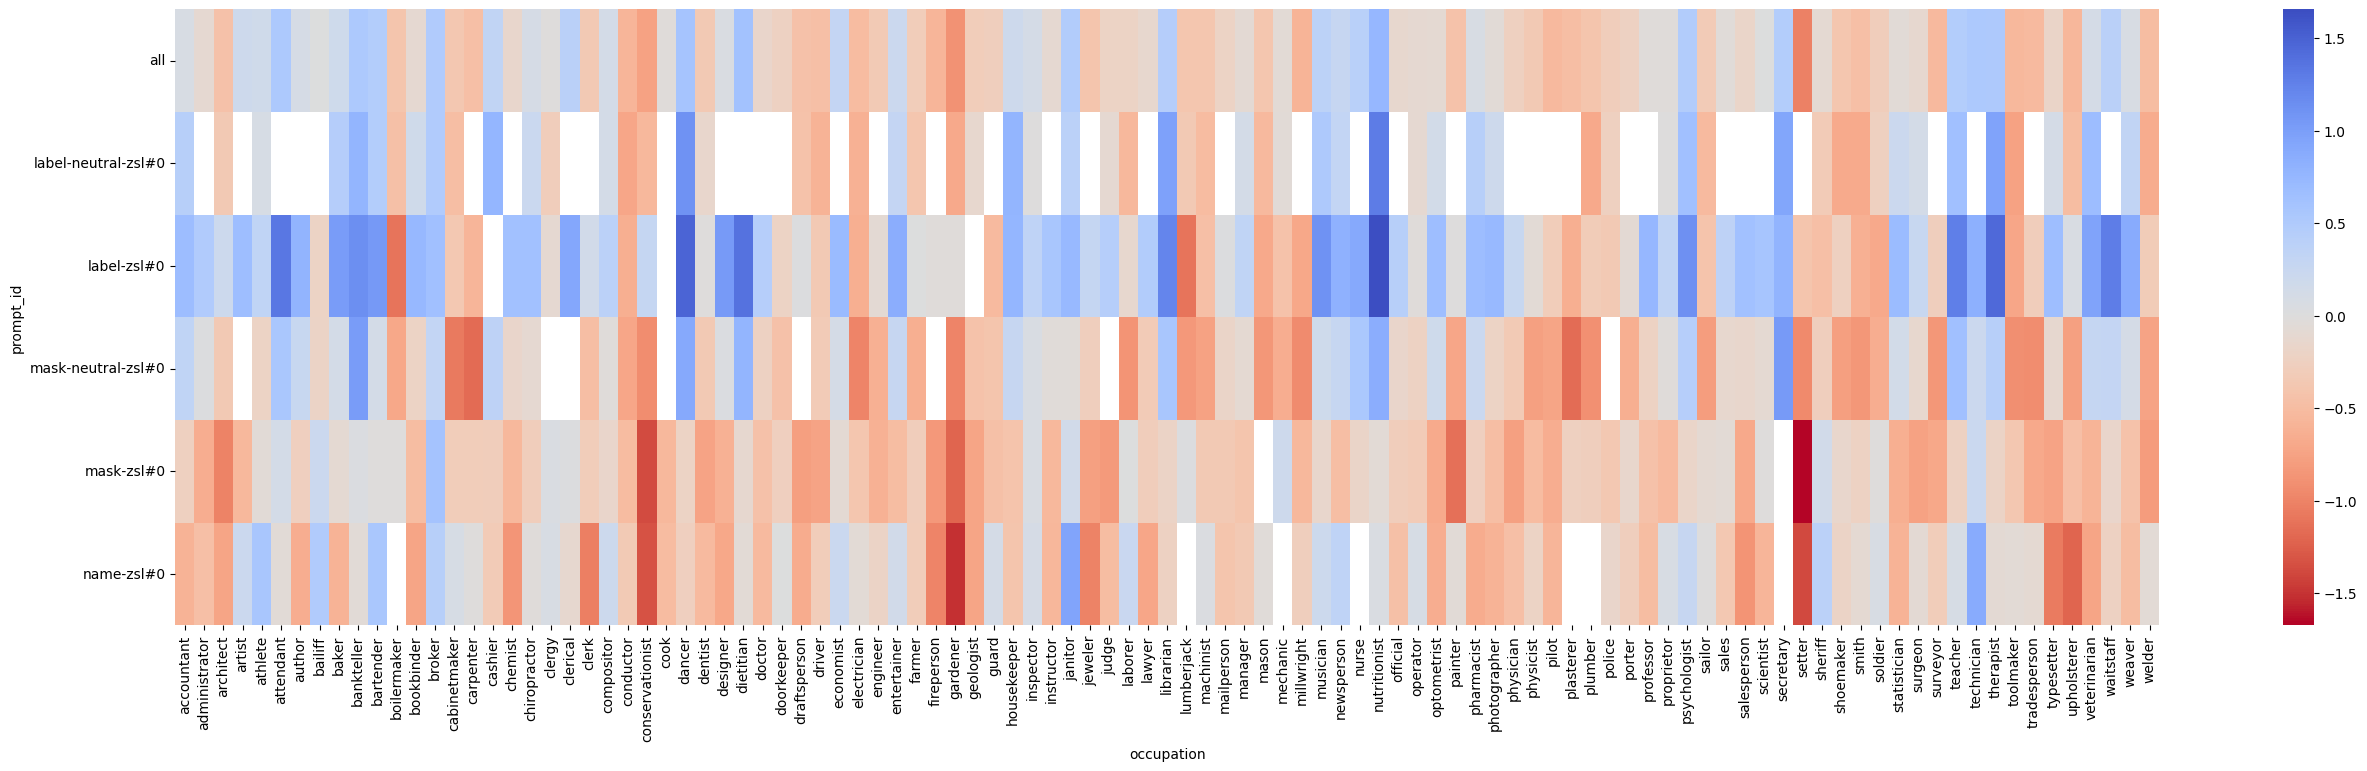

In [280]:
fig, ax = plt.subplots(figsize=(32,8))
sns.heatmap(df_bias.pivot(columns='occupation',index='prompt_id',values='she-he_bias'), cmap='coolwarm_r', center=0, ax=ax)


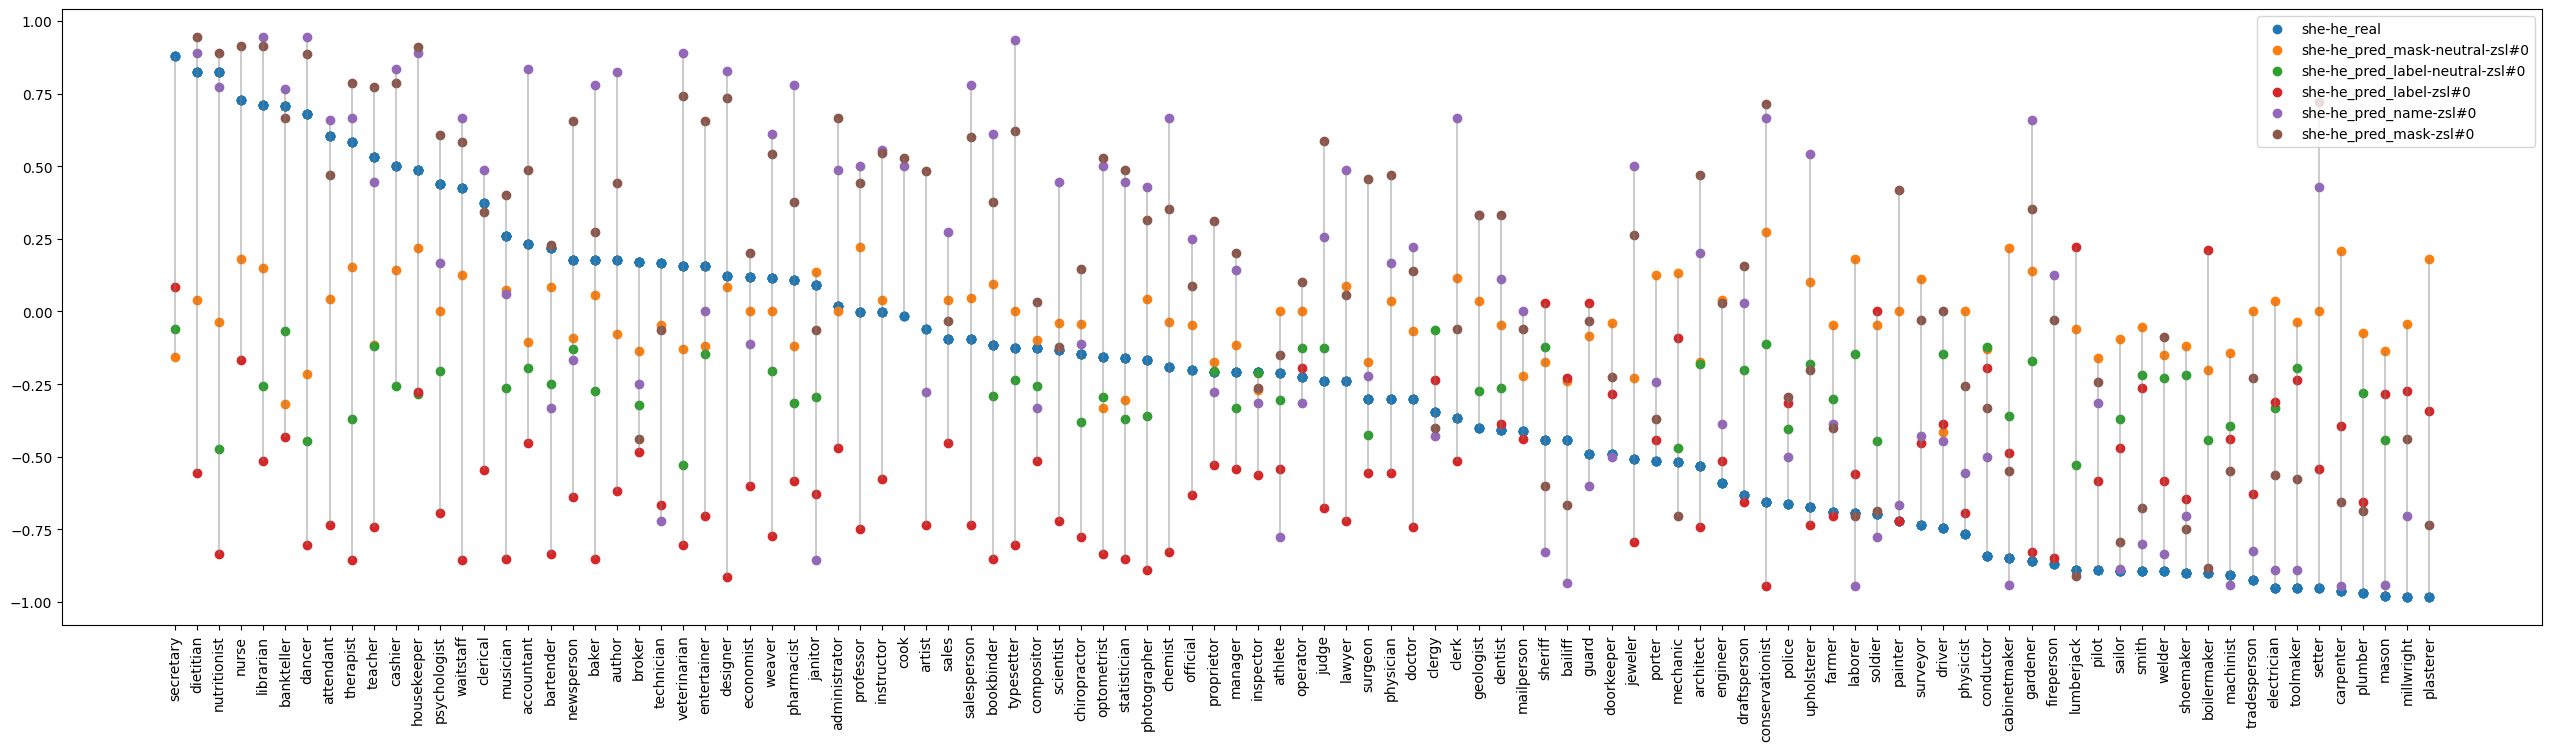

In [293]:
# The horizontal plot is made using the hline function
fig, ax = plt.subplots(figsize=(32,8))
# df_bias_all = df_bias_all.sort_values('she-he_real', ascending=False)
# ax.scatter(df_bias_all['occupation'], df_bias_all['she-he_real'], label='she-he_real')
df_bias = df_bias.sort_values('she-he_real', ascending=False)
ax.scatter(df_bias['occupation'], df_bias['she-he_real'], label='she-he_real')
for p in df_bias['prompt_id'].unique():
    if p == 'all':
        continue
    ax.scatter(df_bias[df_bias['prompt_id'] == p]['occupation'], df_bias[df_bias['prompt_id'] == p]['she-he_pred'], label='she-he_pred_'+str(p))
for i,occ in enumerate(df_bias['occupation'].unique()):
    _v = df_bias[df_bias['occupation'] == occ][['she-he_pred','she-he_real']]
    ax.vlines(x=[occ], ymin=min(_v['she-he_pred'].min(),_v['she-he_real'].min()), ymax=max(_v['she-he_pred'].max(),_v['she-he_real'].max()), color='grey', alpha=0.4)
plt.xticks(rotation=90)
plt.legend()
plt.show()

cs = ax.collections
# make linear interpolation of each prompt_id
for c in cs:
    y = c.get_offsets()[:,1]
    x = c.get_offsets()[:,0]
    # x_new = np.linspace(x.min(), x.max(), 100)
    # y_smooth = np.interp(x_new, x, y)
    coef = np.polyfit(x,y,1)
    poly1d_fn = np.poly1d(coef) 
    # plt.plot(x,y)
    plt.plot(x, poly1d_fn(x), label='fit_'+str(c.get_label()))

plt.show()

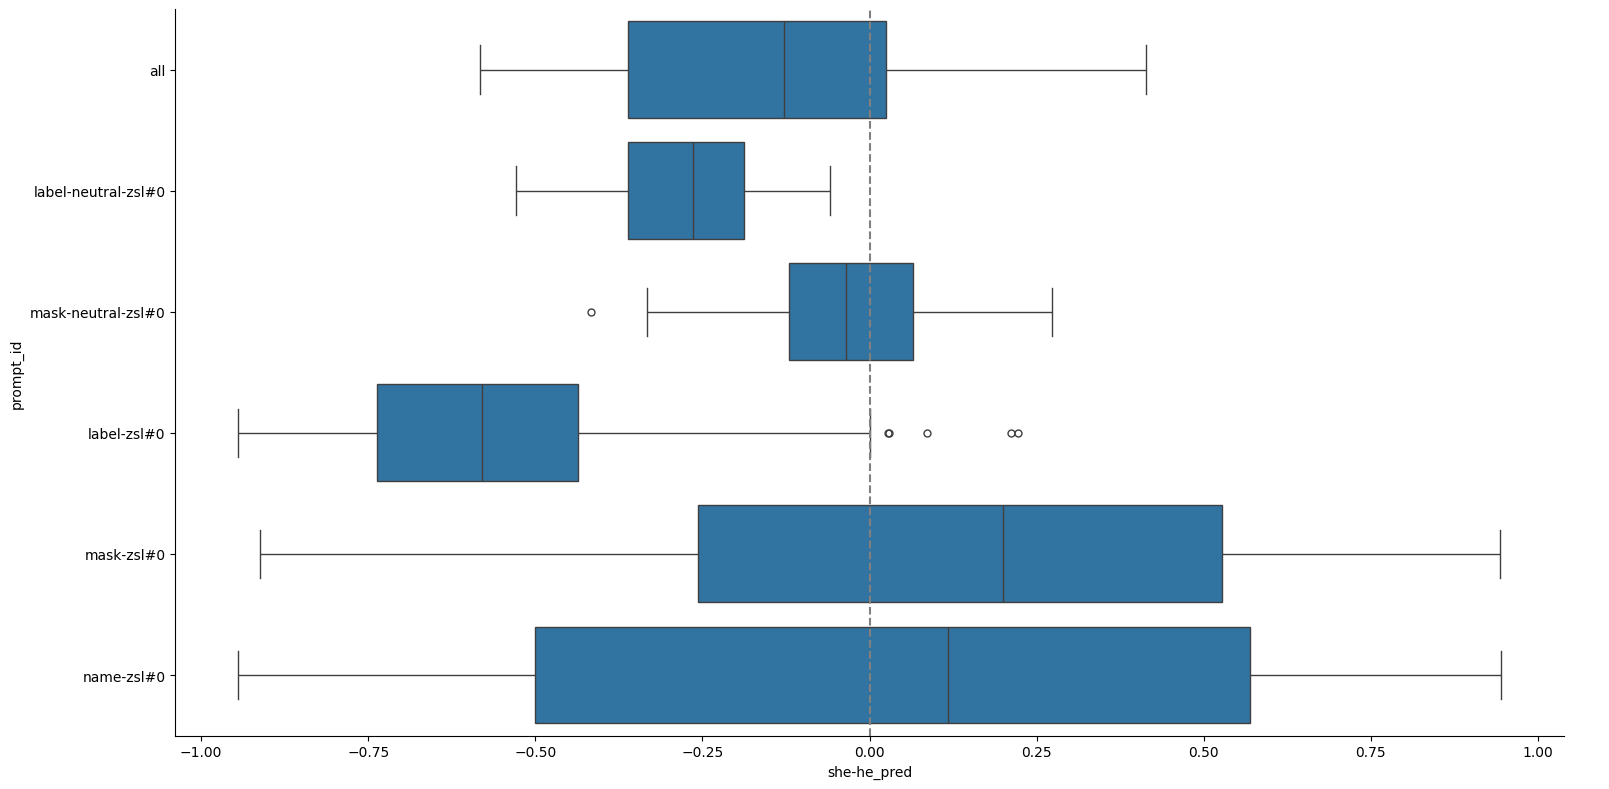

In [292]:
g = sns.catplot(data=df_bias, x="she-he_pred", y="prompt_id", kind='box', height=8, aspect=2)
g.refline(x=0)

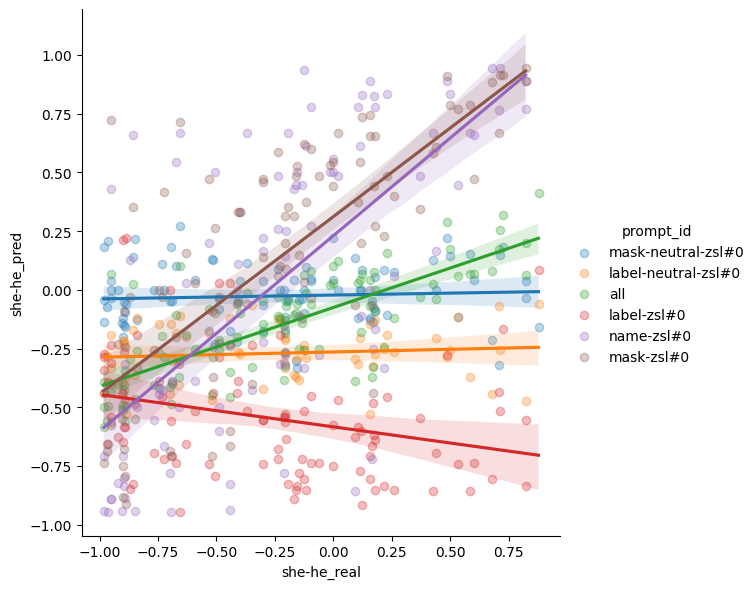

In [305]:
sns.lmplot(data=df_bias, y="she-he_pred", x="she-he_real", hue='prompt_id', height=6, aspect=1, scatter_kws={'alpha': 0.3})

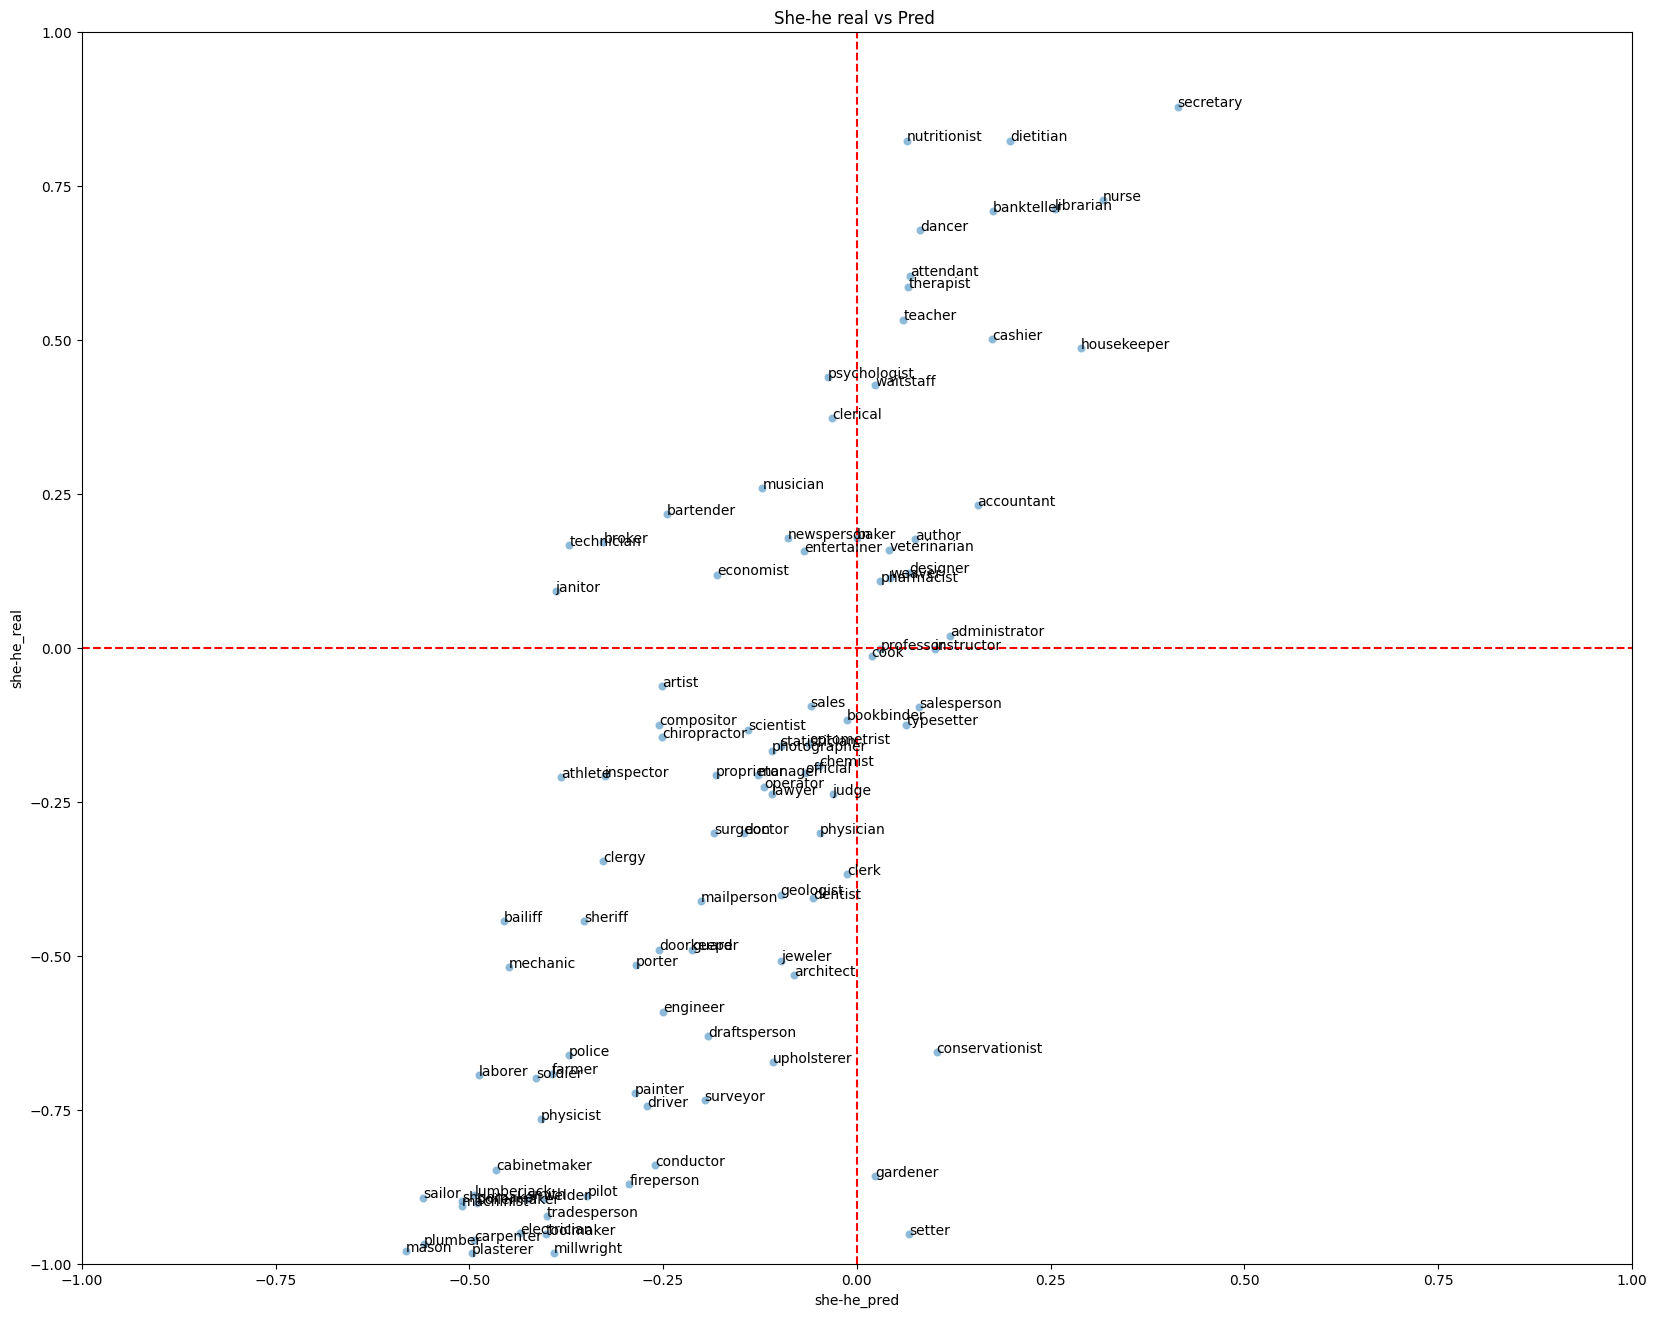

all


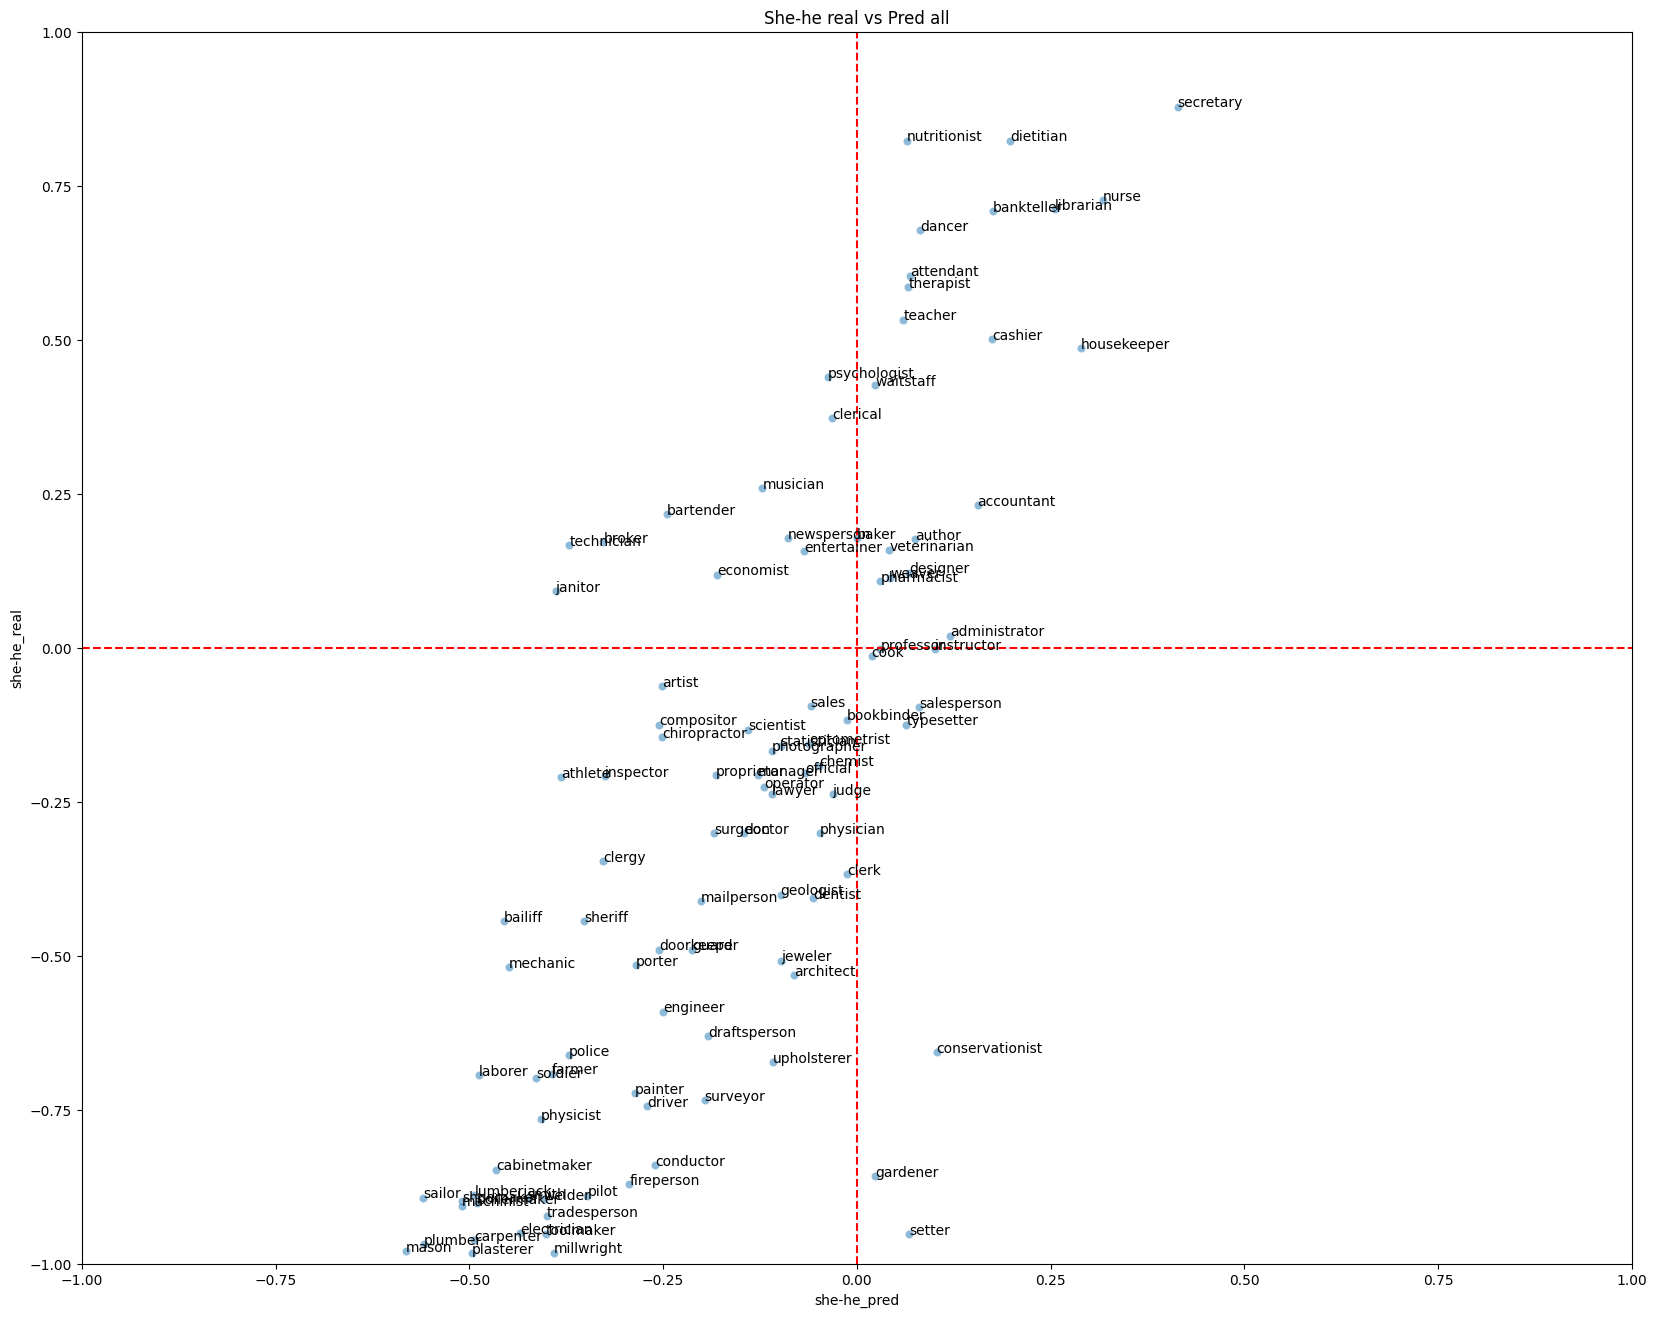

label-neutral-zsl#0


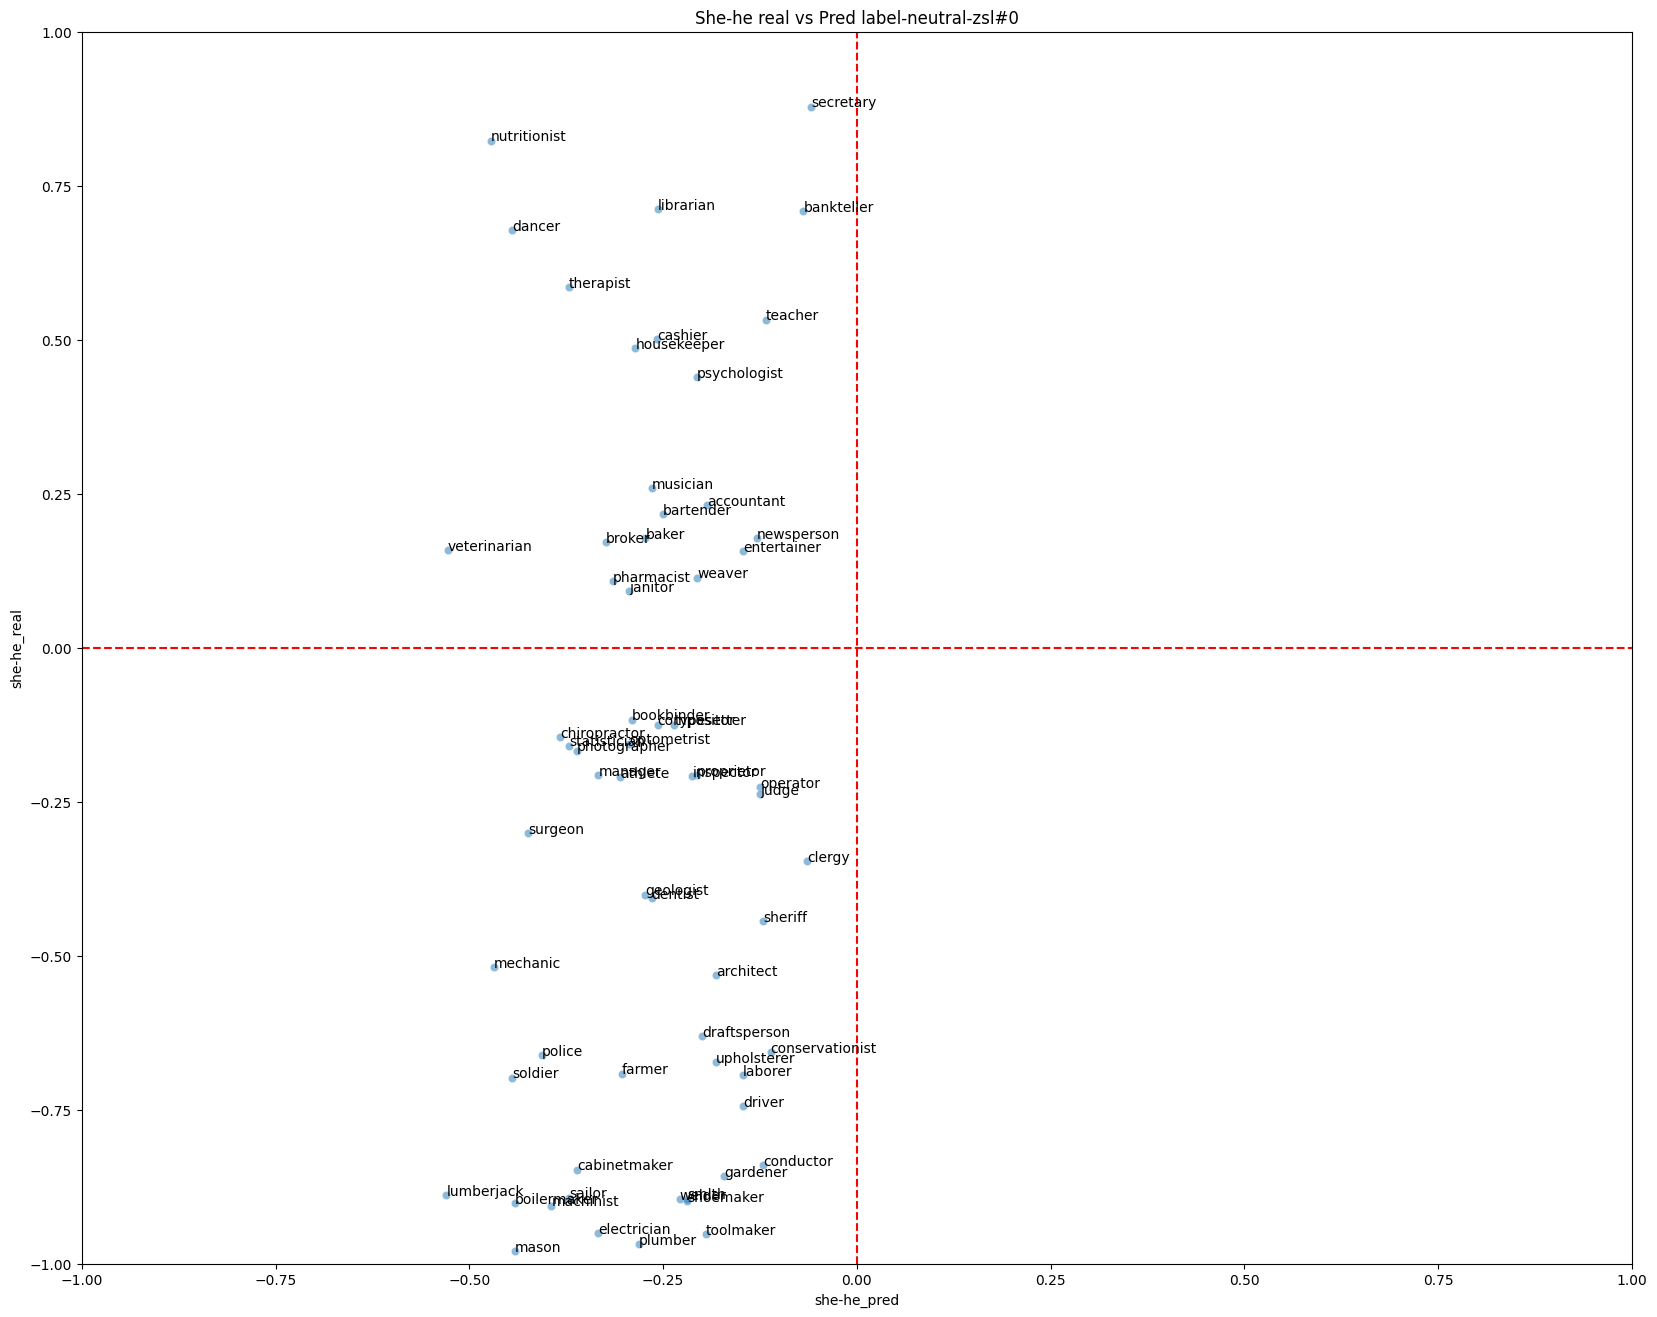

mask-neutral-zsl#0


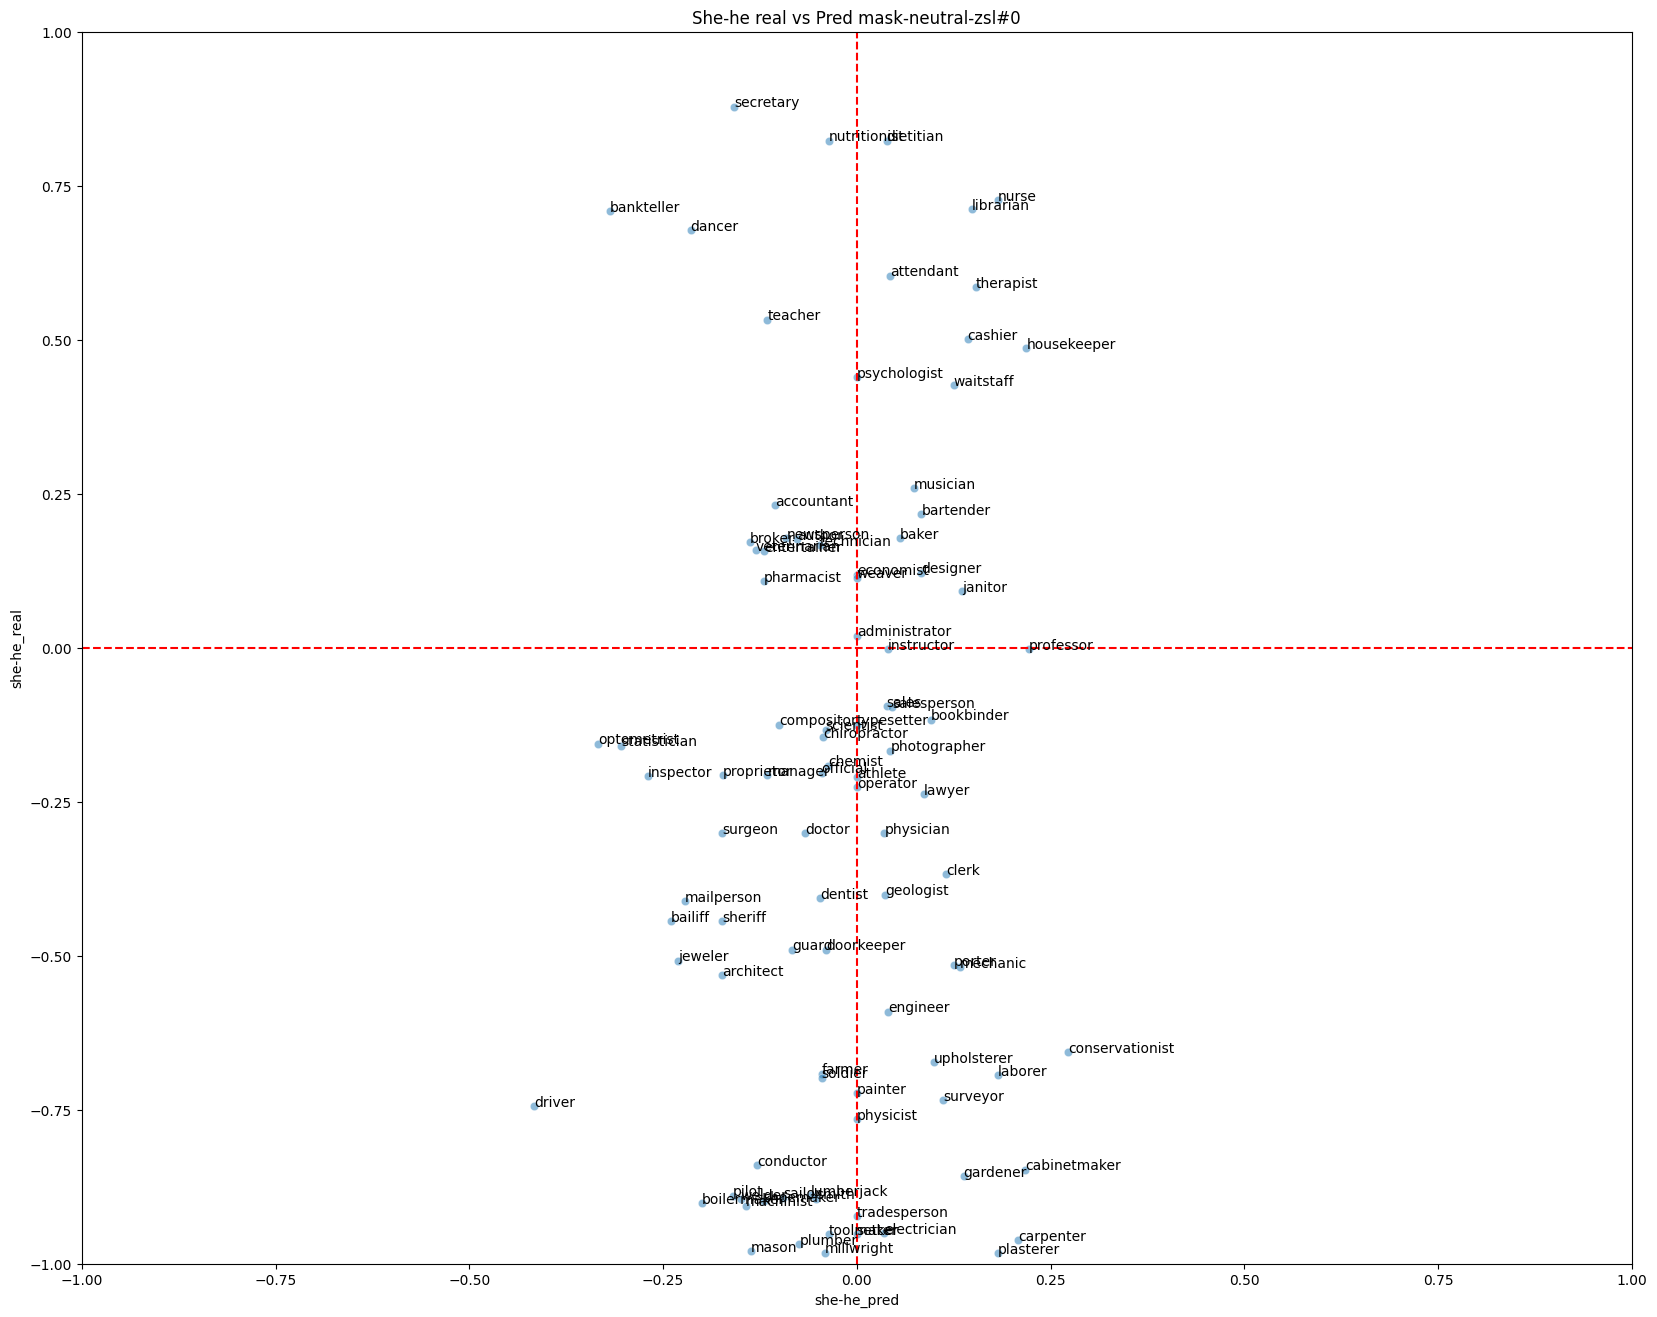

label-zsl#0


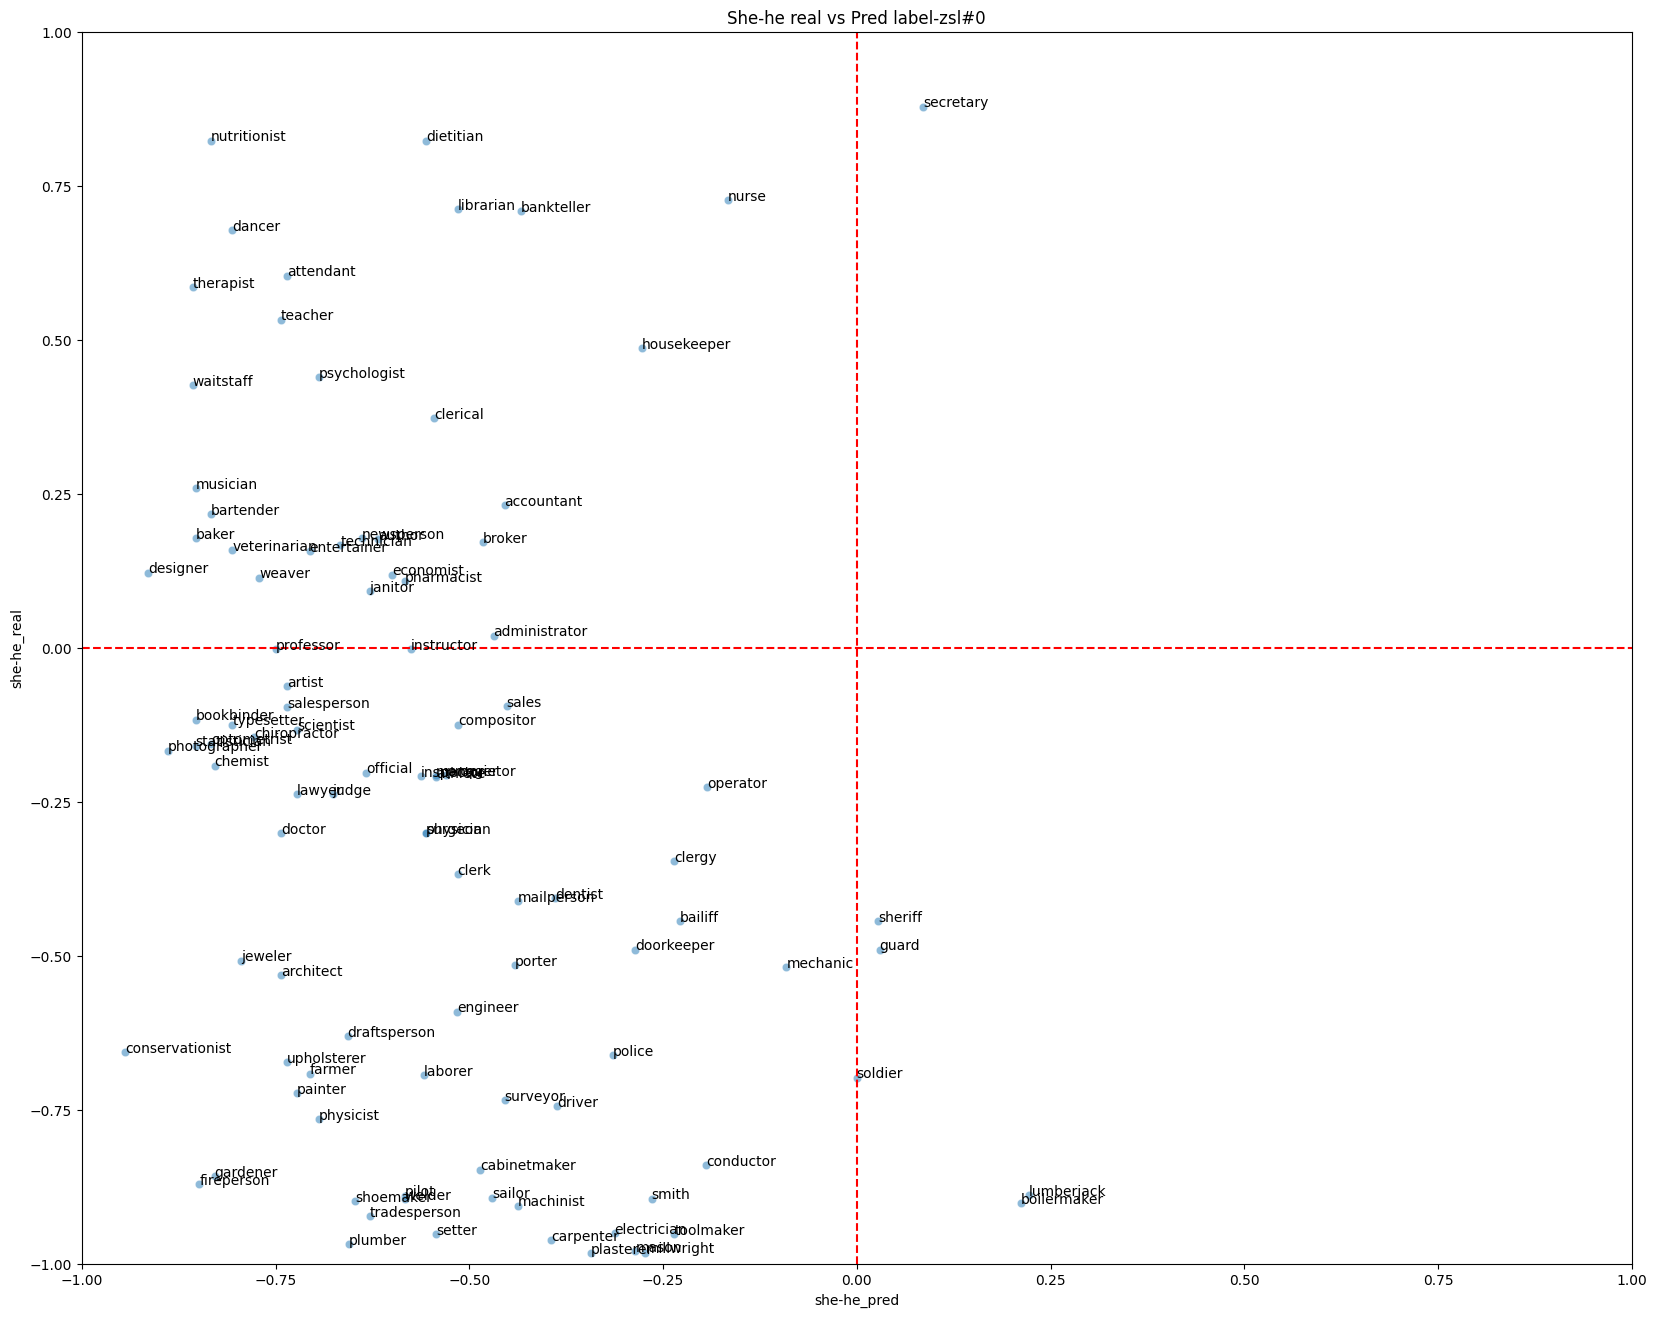

mask-zsl#0


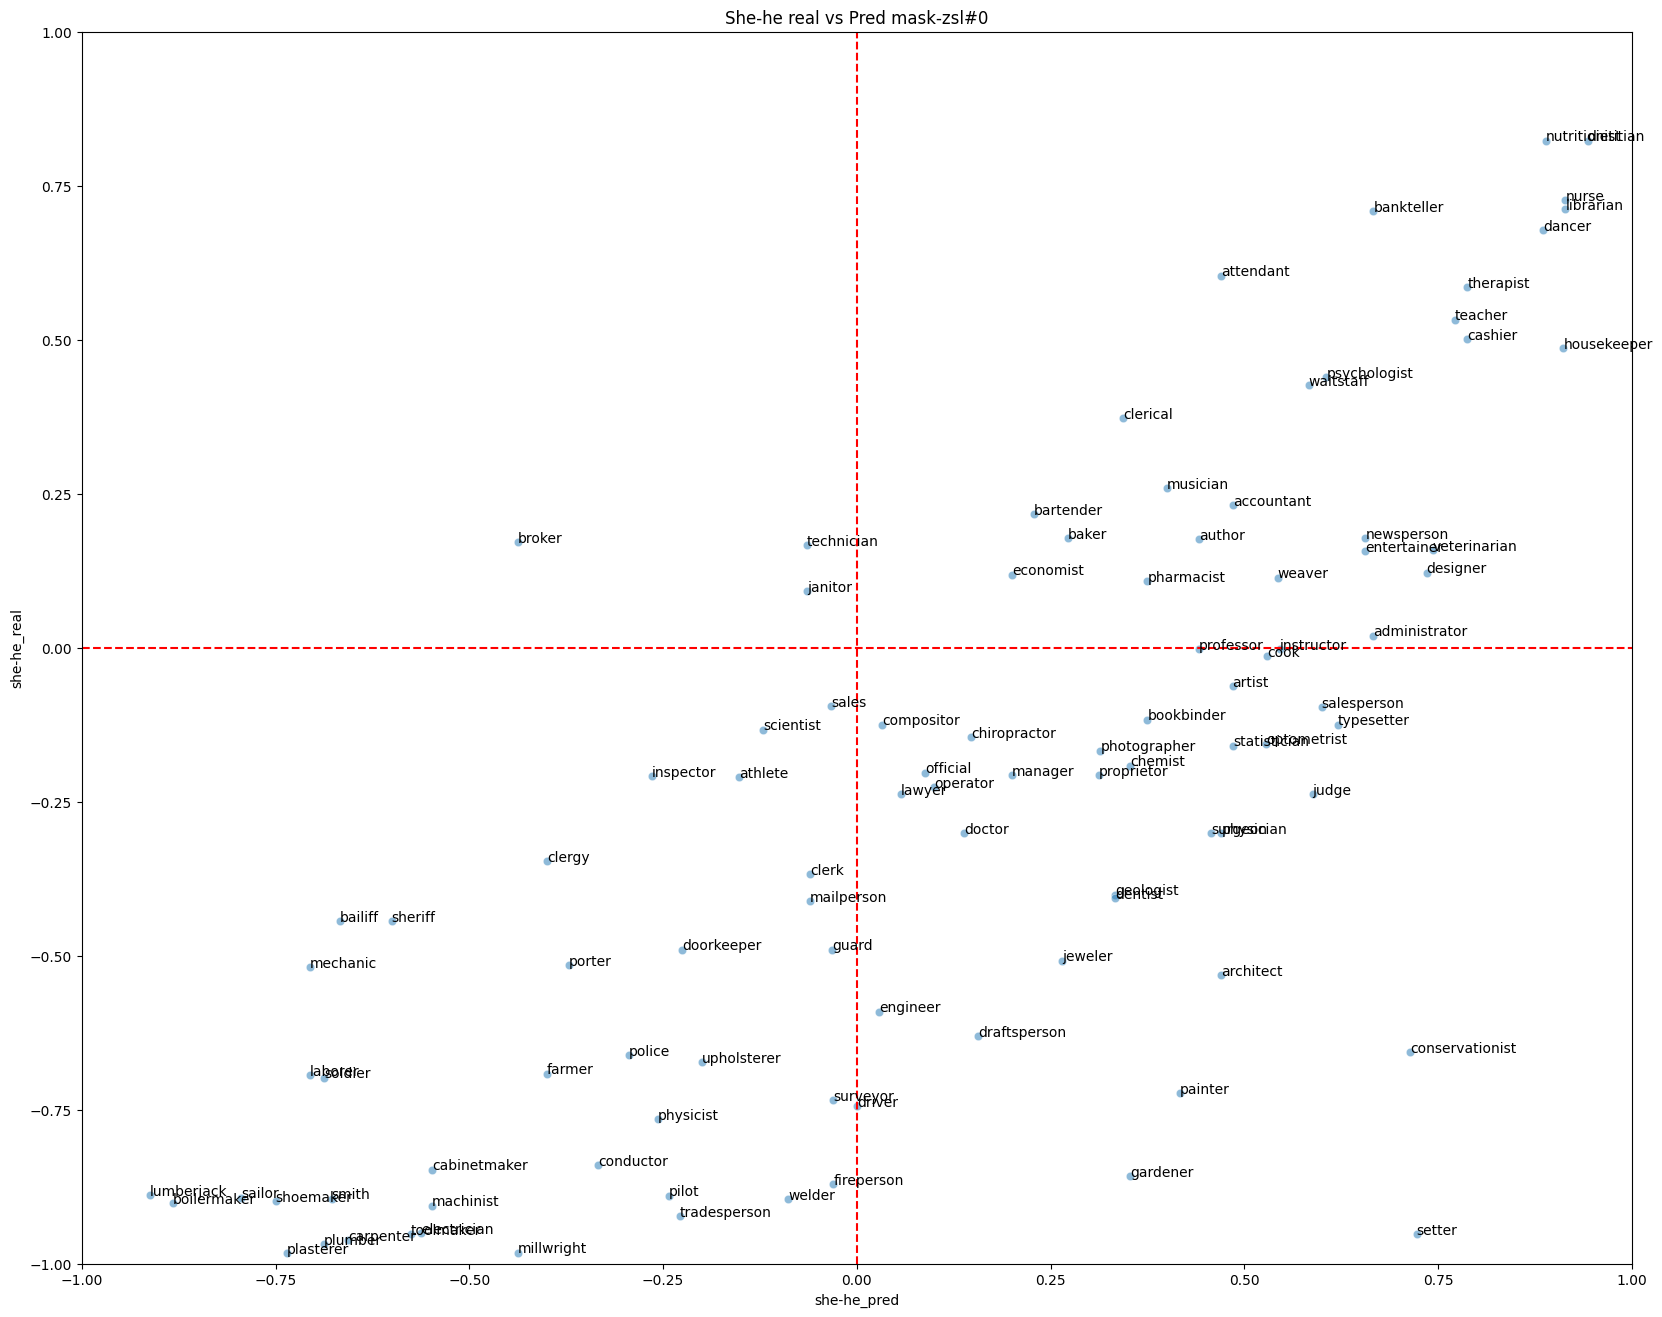

name-zsl#0


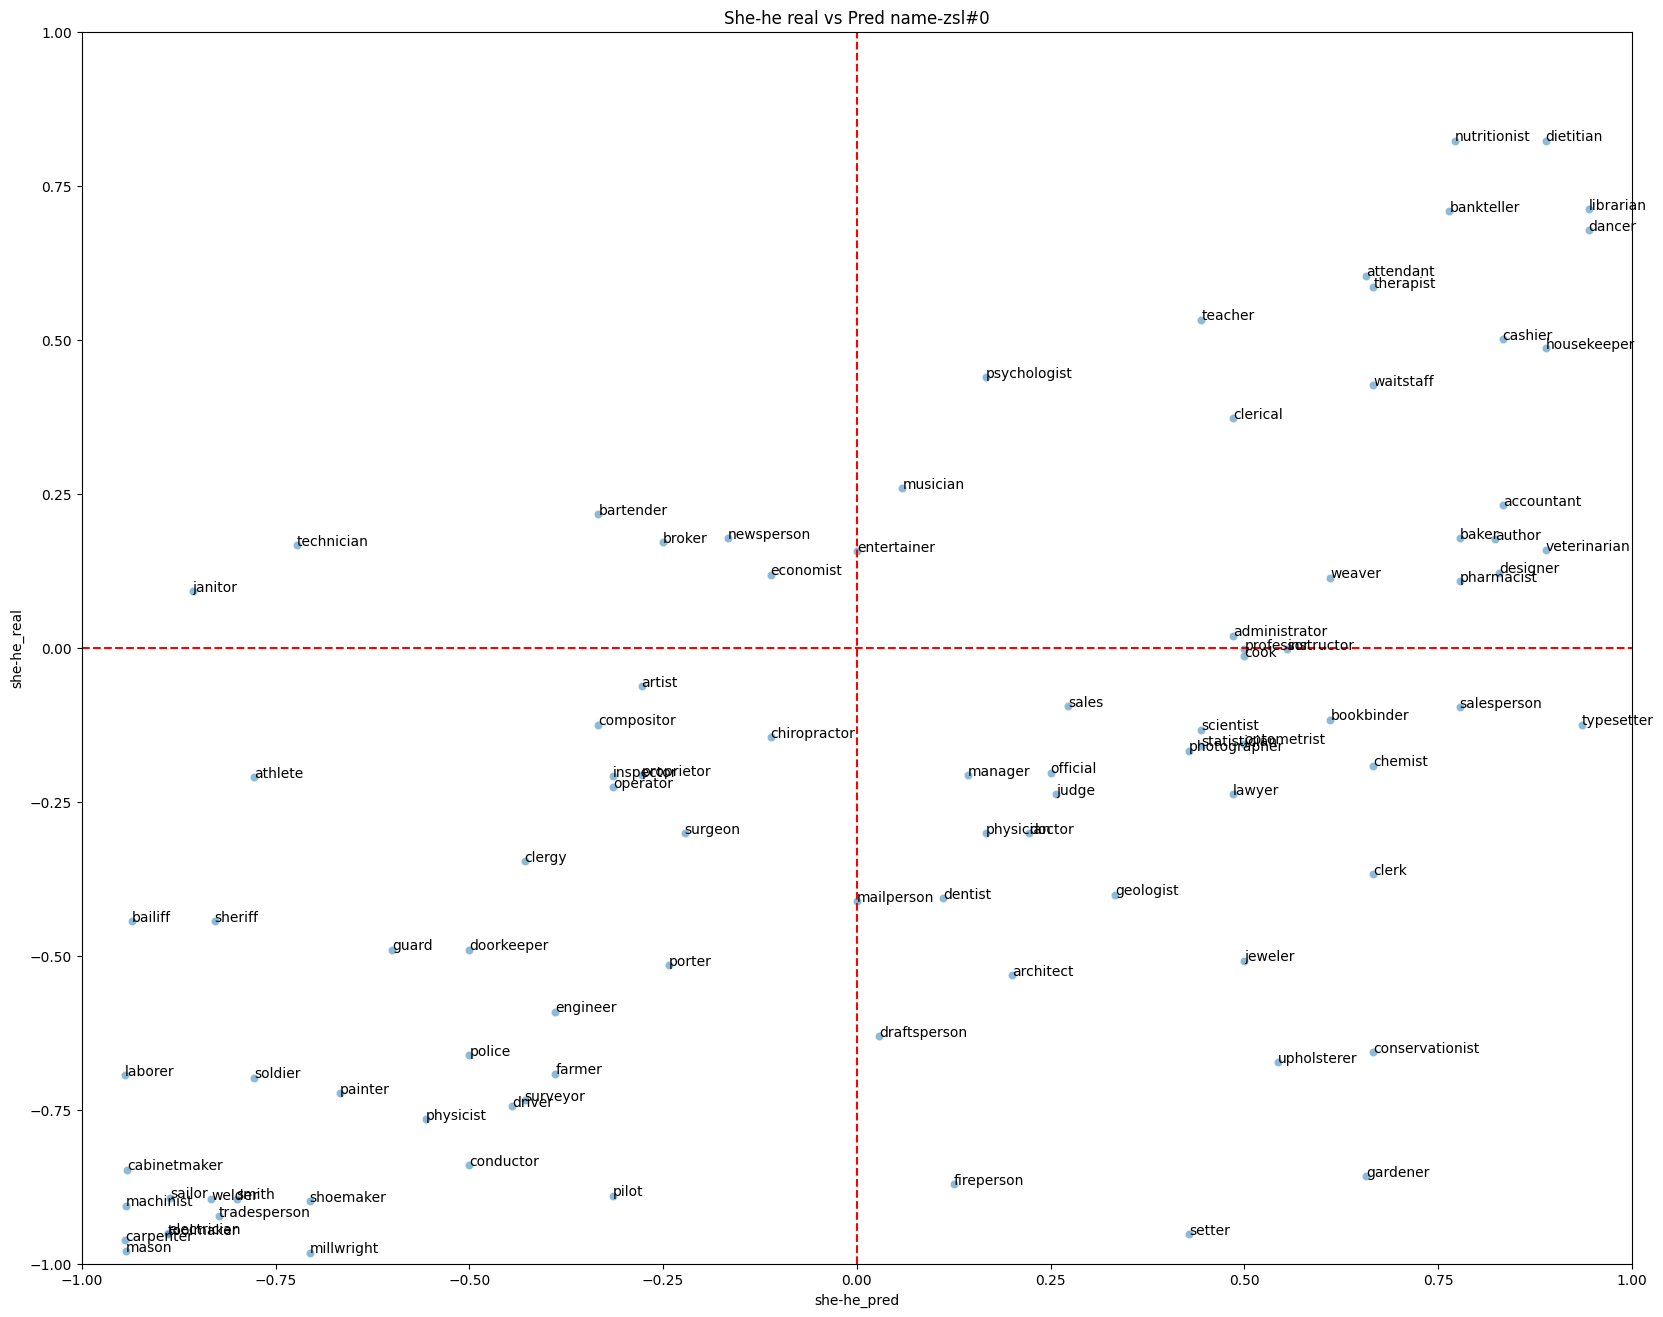

In [284]:
for p in ['',]+list(df_bias['prompt_id'].unique()):
    print(p)
    if p == '':
        df = df_bias_all.copy()
        
    else:
        df = df_bias[df_bias['prompt_id'] == p]

    fig, ax = plt.subplots(figsize=(20, 16))
    sns.scatterplot(data=df, x='she-he_pred', y='she-he_real', alpha=0.5, ax=ax)
    for i, txt in enumerate(df['occupation']):
        ax.annotate(txt, (df['she-he_pred'].iloc[i], df['she-he_real'].iloc[i]))
    ax.axvline(0, color='r', linestyle='--')
    ax.axhline(0, color='r', linestyle='--')
    # ax.text(0.0,0.0, 'male', color='r', fontsize=18, transform=ax.transAxes)
    # ax.text(1.0,1.0, 'female', color='r', fontsize=18, transform=ax.transAxes)
    # ax.text(0.0,1.0, 'female stats\nmale pred', fontsize=18, color='r', transform=ax.transAxes)
    # ax.text(1.0,0.0, 'male stats\nfemale pred', color='r', fontsize=18, transform=ax.transAxes)
    ax.set_xlim(-1,1)
    ax.set_ylim(-1,1)
    plt.title('She-he real vs Pred '+p)
    plt.show()

    # g = sns.lmplot(data=df, x='she-he_pred', y='she-he_real')
    # g.set(xlim=(-1, 1), ylim=(-1, 1))
    # plt.show()


In [285]:
assert 1 == 2

AssertionError: 

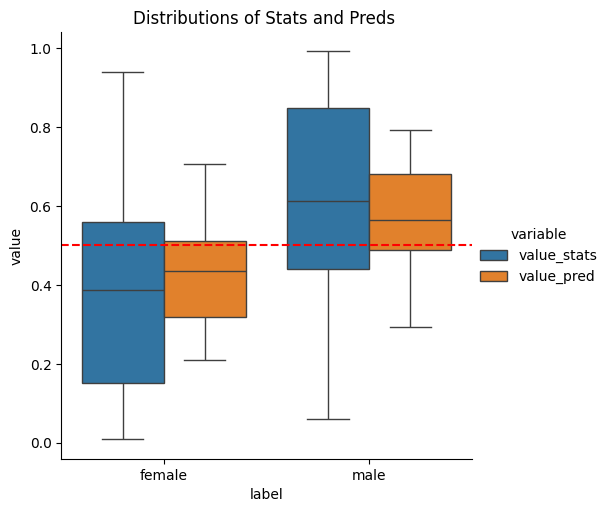

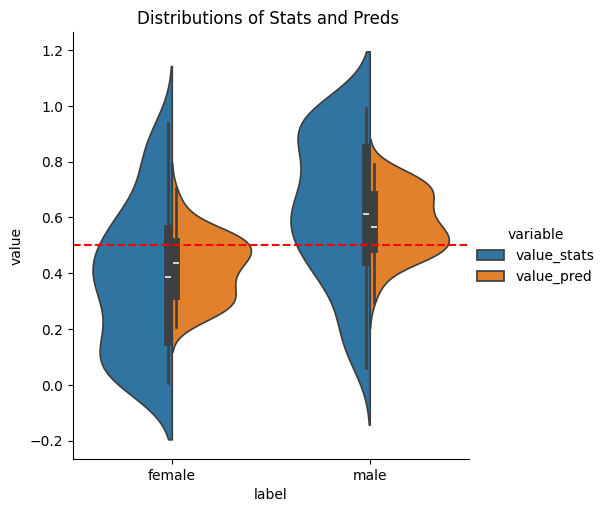

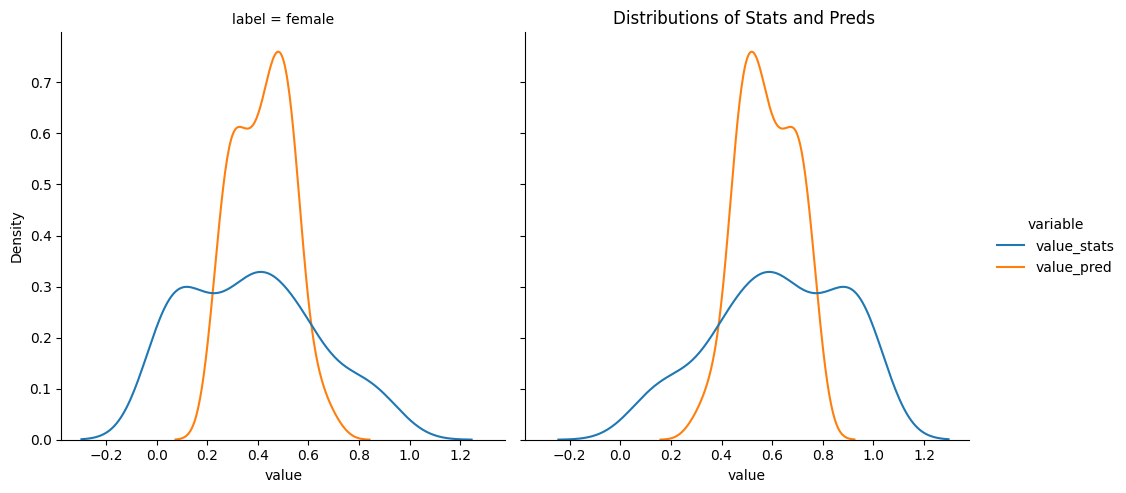

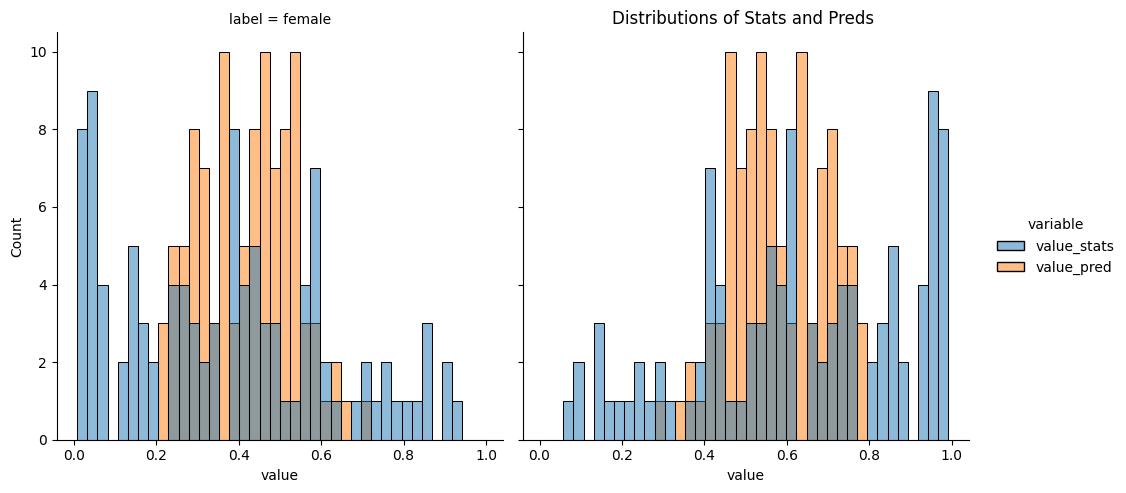

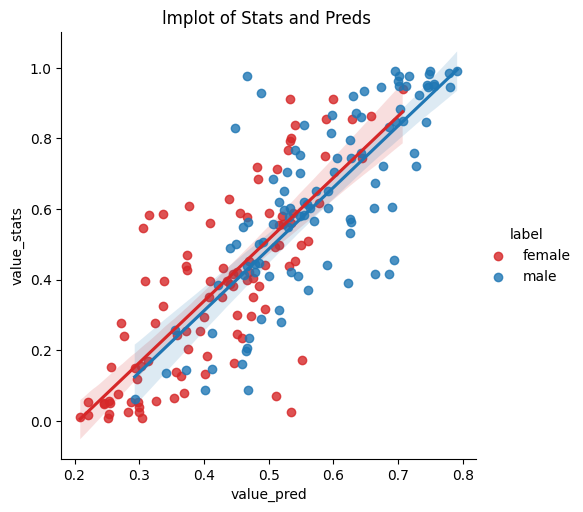

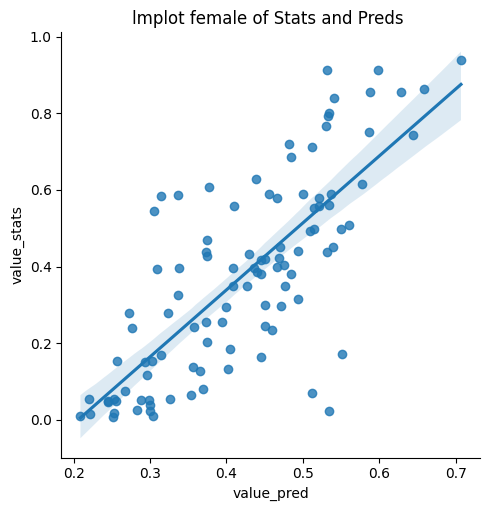

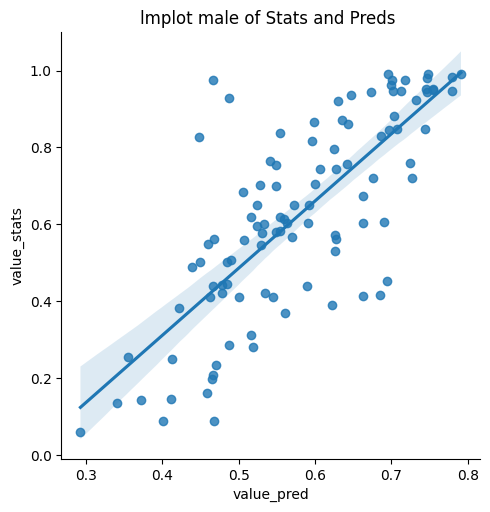

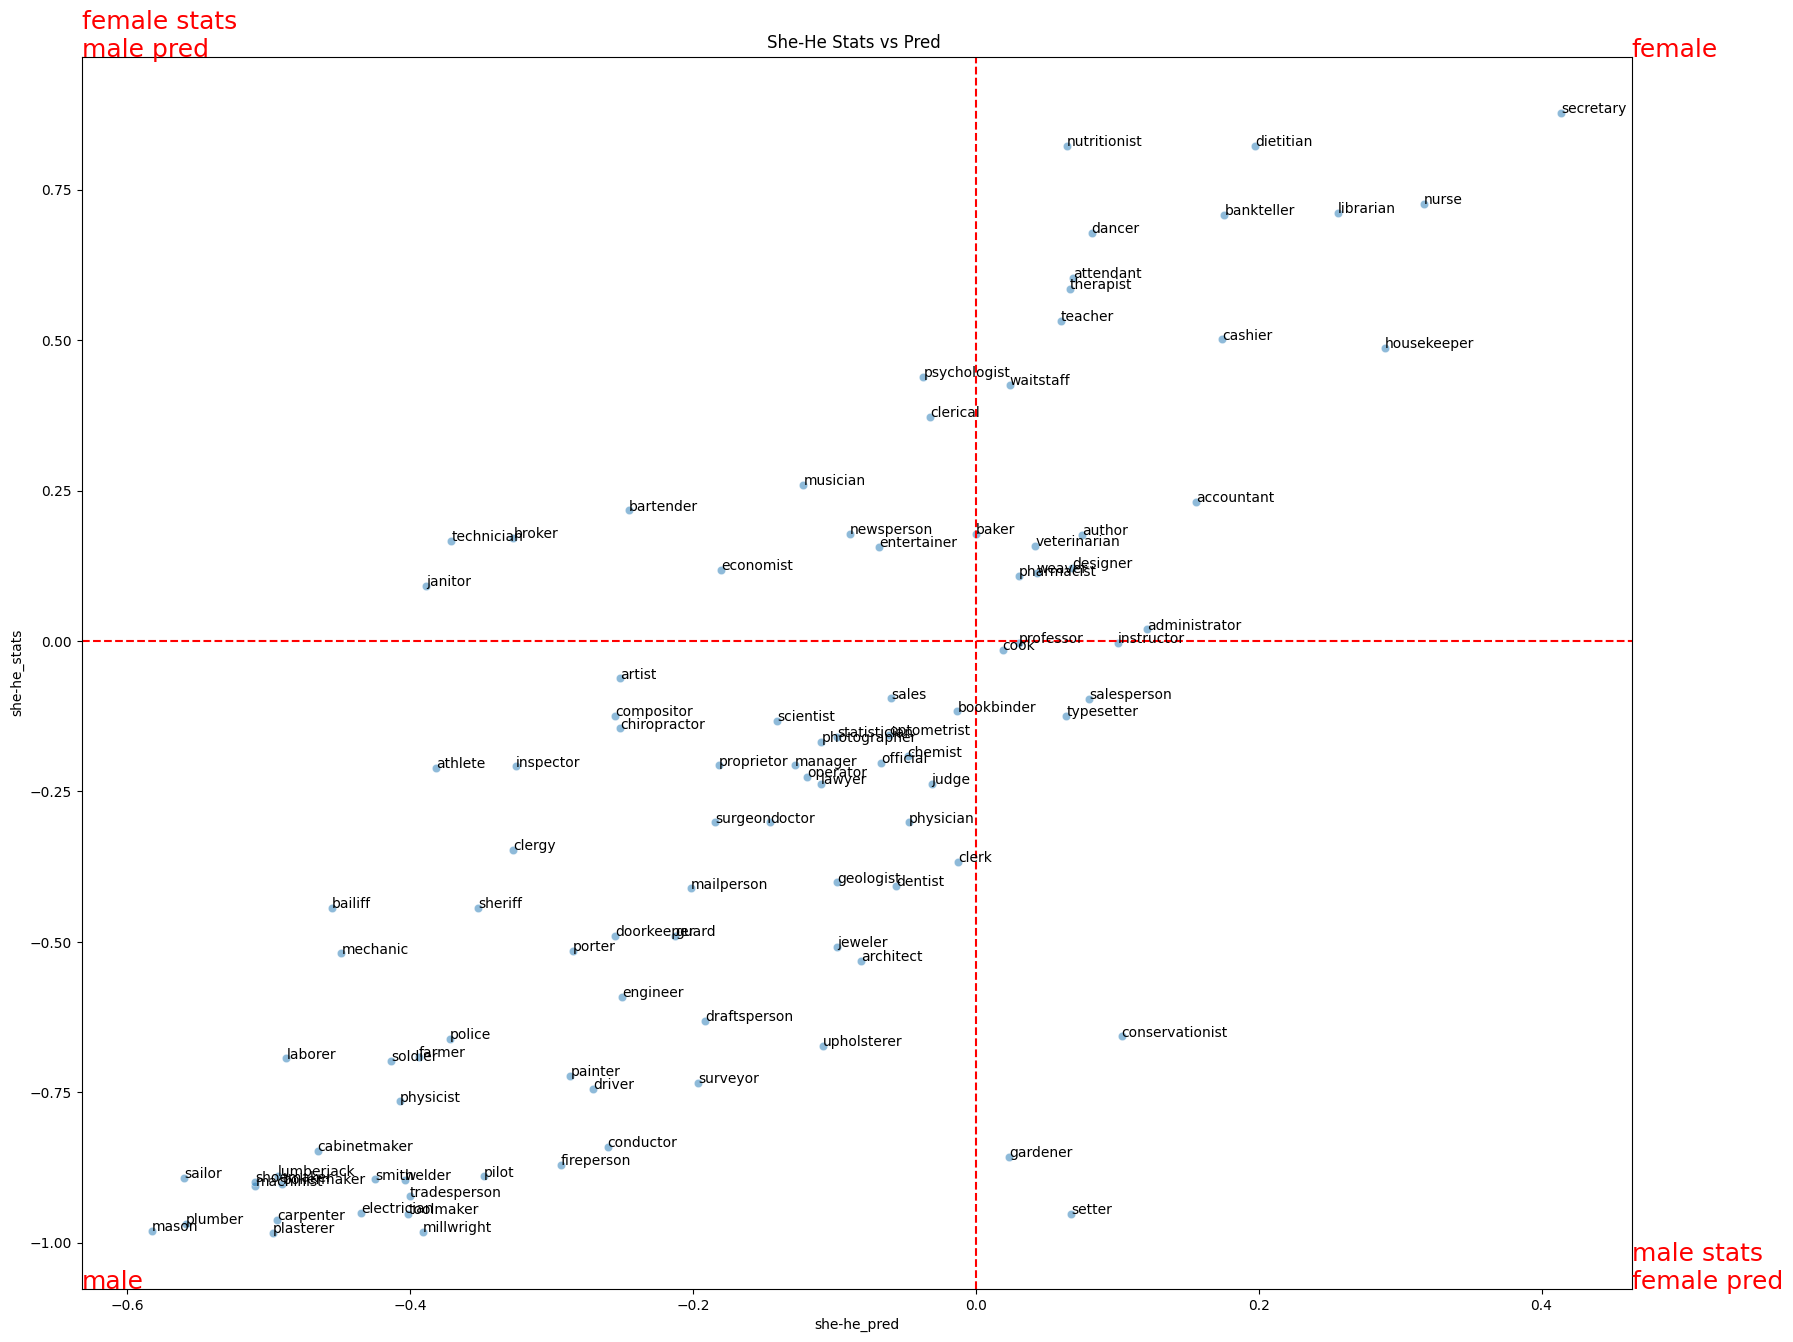

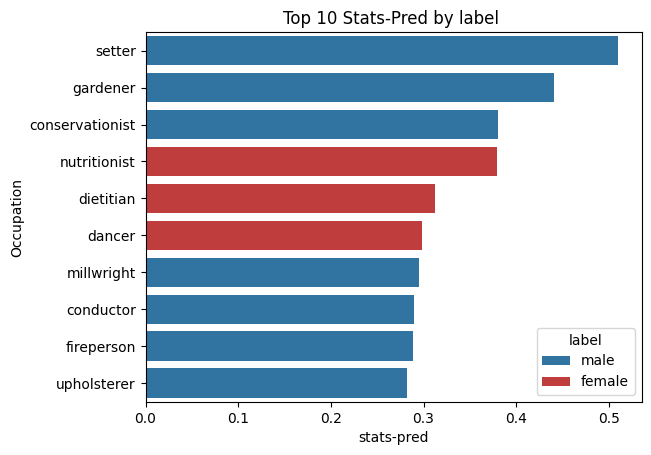

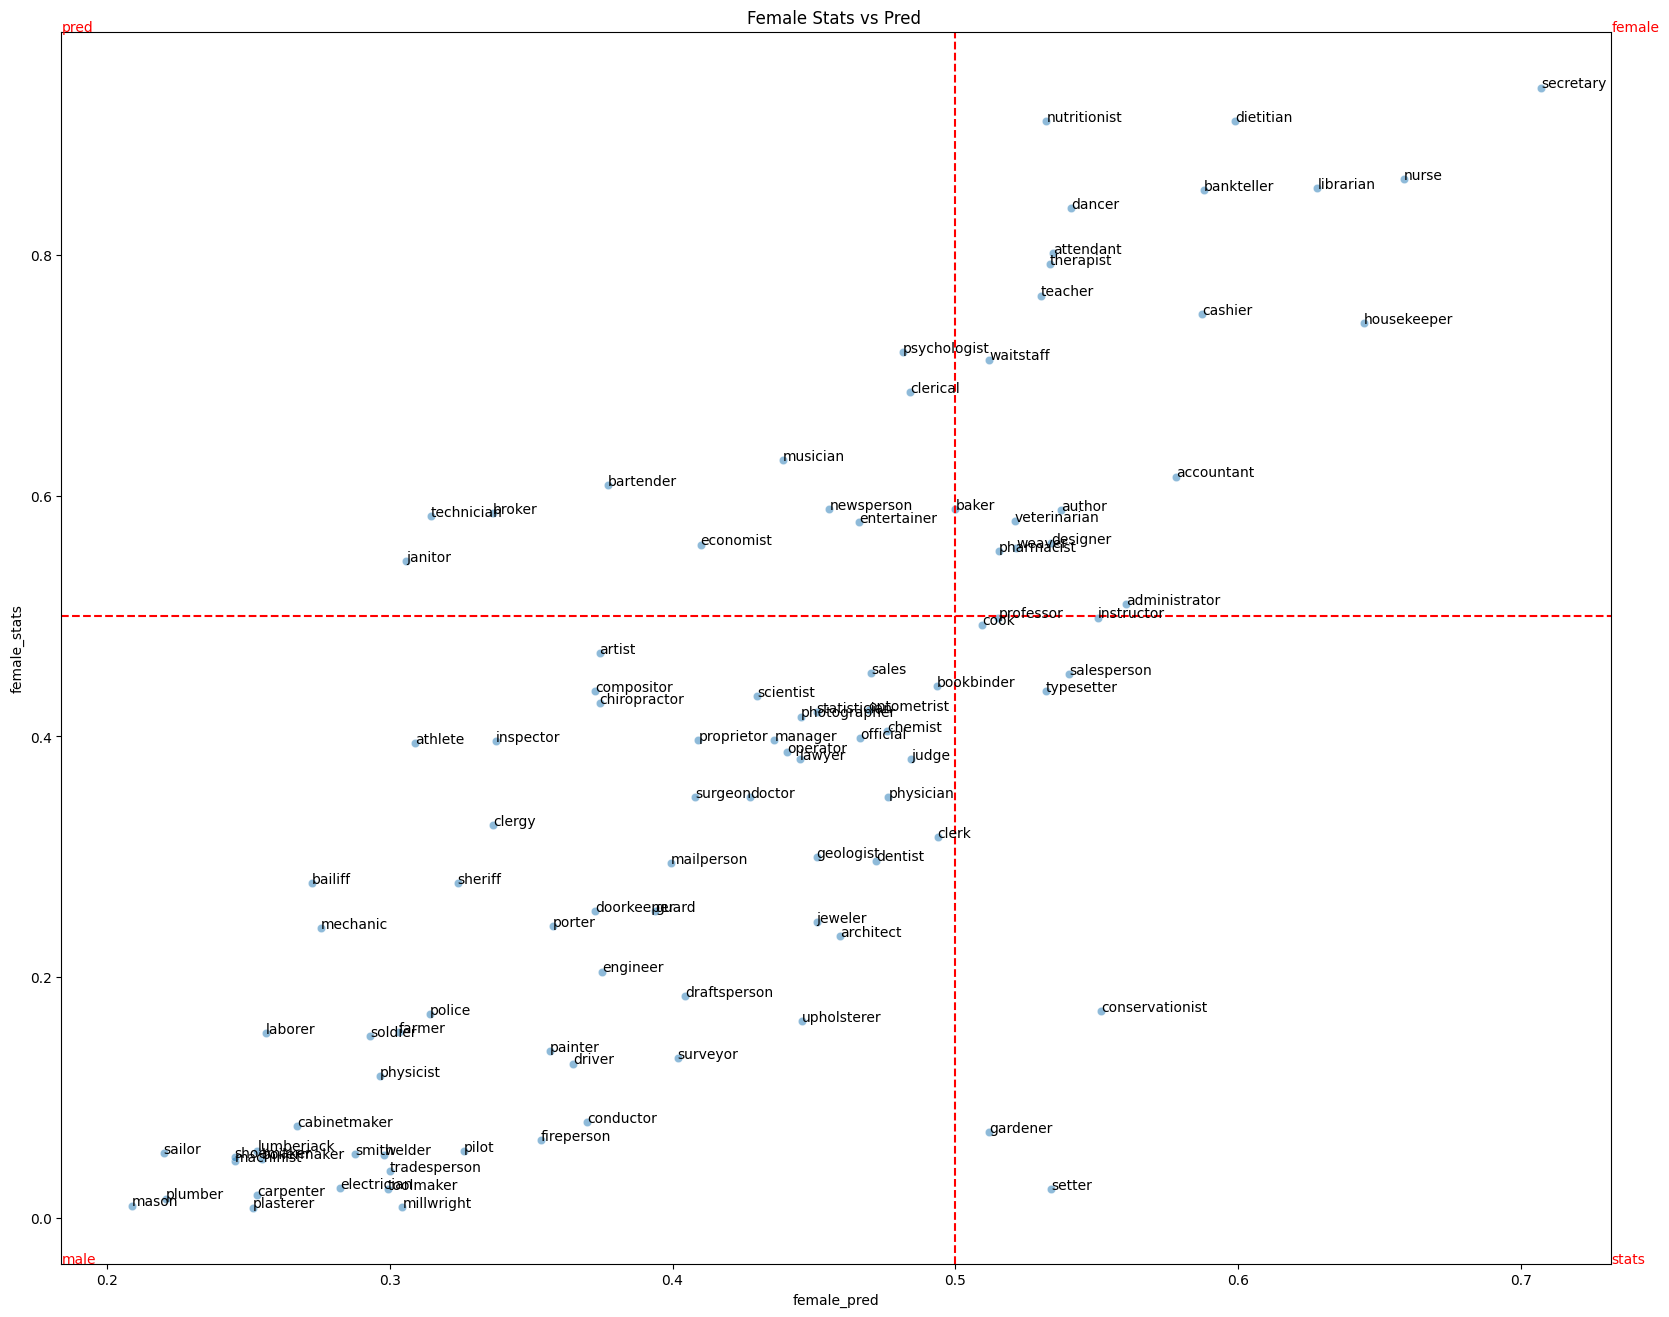

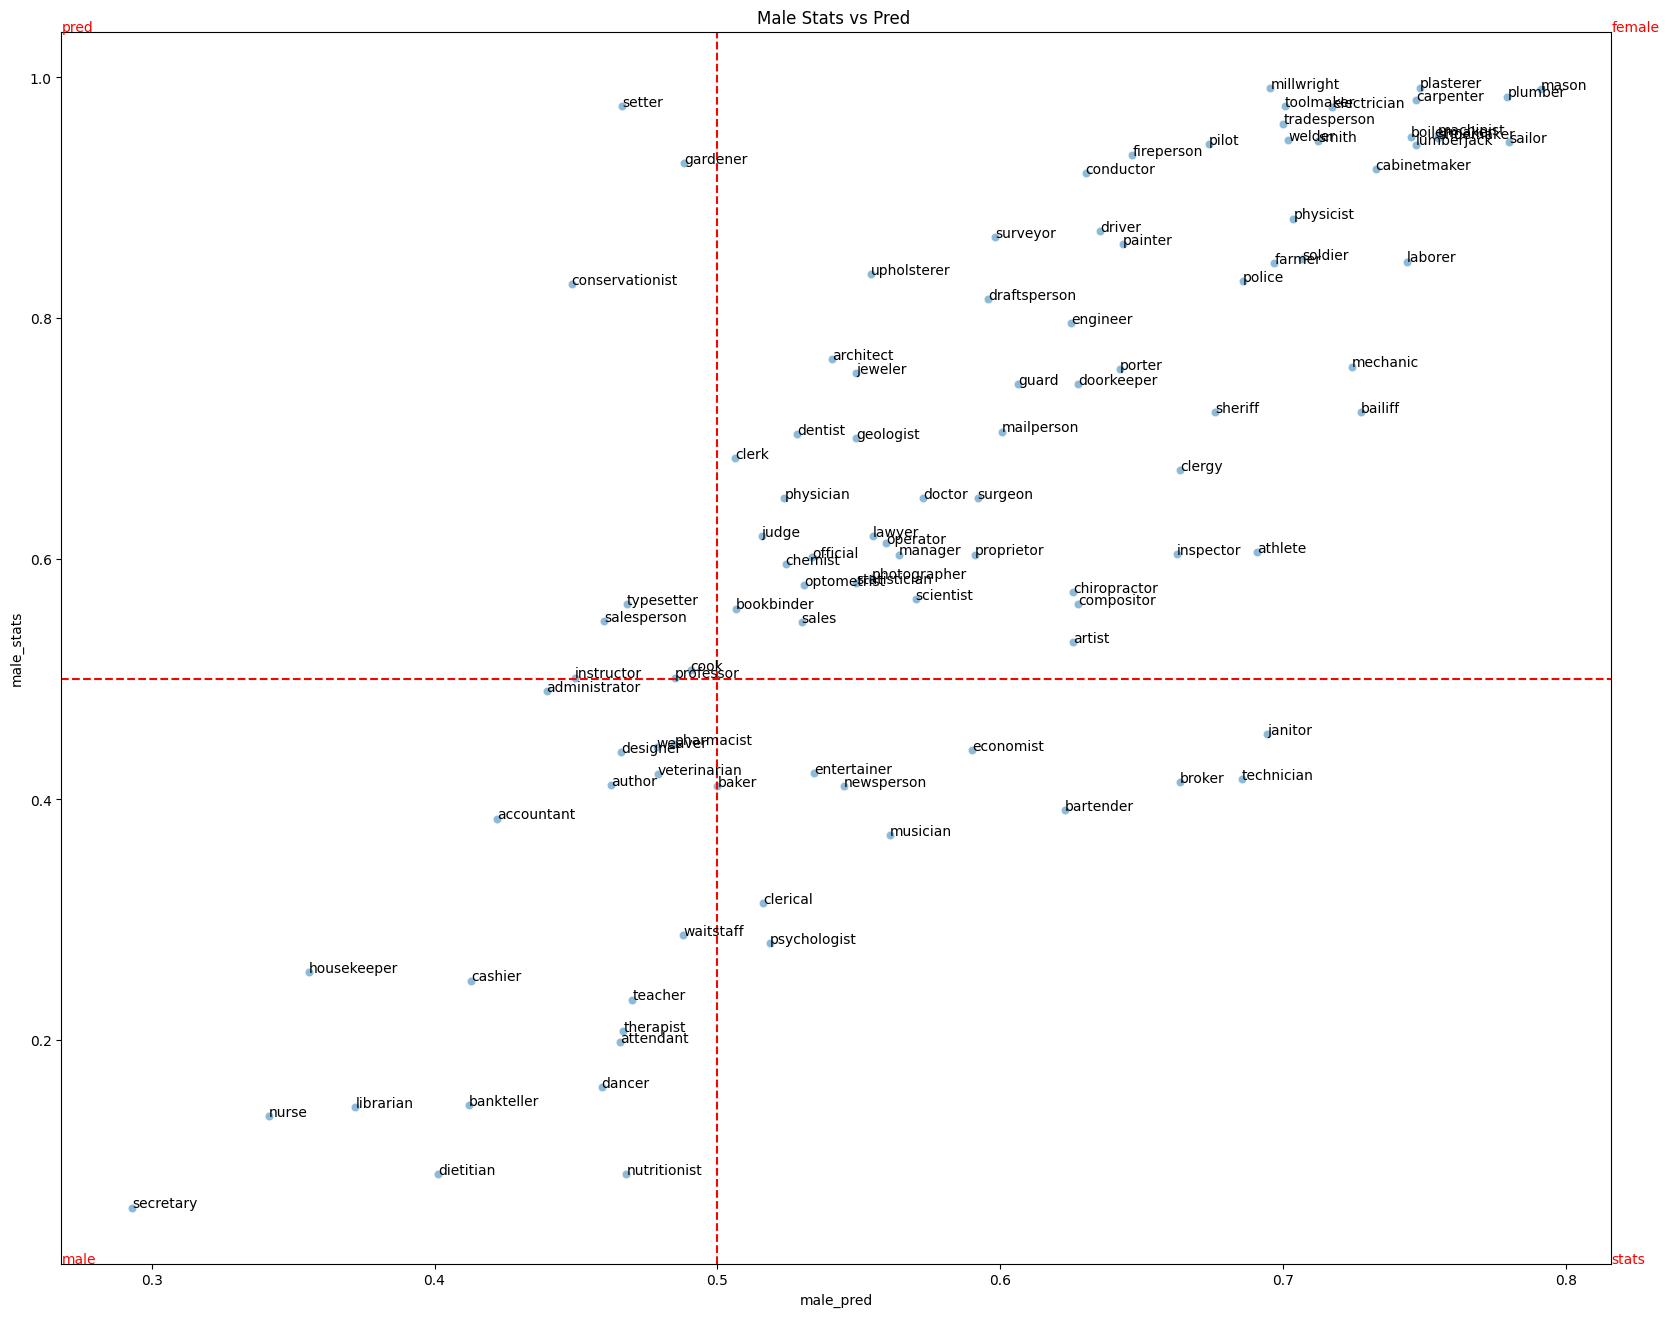

In [ ]:
df_original_res = pd.read_csv('llama_results.csv')
for p in ['',]+df_original_res['prompt_id'].unique().tolist():
    print(p)
    if p == '':
        df = df_original_res.copy()
    else:
        df = df_original_res[df_original_res['prompt_id'] == p]
    df['response'] = df.apply(lambda x: str(x['response']).lower(), axis=1)
    df = fix_responses(df)
    df = normalize_labels(df)

    gc = group_count(df, 'text_JOB_value', hue='response', n=-1)
    dfp = pivot_df(gc, 'text_JOB_value', 'response', 'proportion_by')
    dfp = dfp.replace({np.nan: 0})
    # 	text_JOB_value	female	male	neutral
    # 0	dietitian	0.971429	0.028571	0.000000

    df_pred = dfp.copy()
    df_pred['male'] = df_pred.apply(lambda x: x['male']+(x['neutral']/2), axis=1)
    df_pred['female'] = df_pred.apply(lambda x: x['female']+(x['neutral']/2), axis=1)
    df_pred.drop(columns=['neutral'], inplace=True)
    df_pred_melt = pd.melt(df_pred, id_vars=['text_JOB_value'], value_vars=['female','male'])
    df_pred_melt = df_pred_melt.sort_values('value', ascending=False)
    # text_JOB_value	variable	value
    # 205	mason	male	0.984375

    df_merged = pd.merge(df_stats, df_pred, left_on='Occupation', right_on='text_JOB_value')
    df_merged = df_merged.rename(columns={'Female': 'female_stats','Male':'male_stats','female':'female_pred','male':'male_pred'})
    df_merged = df_merged[['Occupation','female_stats','male_stats','male_pred','female_pred']]
    df_merged['she-he_stats'] = df_merged.apply(lambda x: x['female_stats']-x['male_stats'], axis=1)
    df_merged['she-he_pred'] = df_merged.apply(lambda x: x['female_pred']-x['male_pred'], axis=1)
    df_merged['female_stats-pred'] = df_merged.apply(lambda x: x['female_stats']-x['female_pred'], axis=1)
    df_merged['male_stats-pred'] = df_merged.apply(lambda x: x['male_stats']-x['male_pred'], axis=1)
    # Occupation	female_stats	male_stats	male_pred	female_pred	she-he_stats	she-he_pred	female_stats-pred	male_stats-pred
    # 0	bankteller	0.854076	0.145924	0.166667	0.833333	0.708151	0.666667	0.020742	-0.020742

    df_mms = pd.melt(df_merged, id_vars=['Occupation'], value_vars=['female_stats','male_stats'])
    df_mms = df_mms.rename(columns={'variable':'label_stats','value':'value_stats'})
    df_mmp = pd.melt(df_merged, id_vars=['Occupation'], value_vars=['female_pred','male_pred'])
    df_mmp = df_mmp.rename(columns={'variable':'label_pred','value':'value_pred'})
    df_mm = pd.merge(df_mms, df_mmp, left_on='Occupation', right_on='Occupation')
    df_mm['label'] = df_mm.apply(lambda x: x['label_stats'].split('_')[0] == x['label_pred'].split('_')[0], axis=1)
    df_mm = df_mm[df_mm['label']]
    df_mm['label'] = df_mm.apply(lambda x: x['label_stats'].split('_')[0], axis=1)
    df_mm.drop(columns=['label_stats','label_pred'], inplace=True)
    df_mm['stats-pred'] = df_mm.apply(lambda x: x['value_stats']-x['value_pred'], axis=1)
    # Occupation	value_stats	value_pred	label   stats-pred
    # 0	bankteller	0.854076	0.833333	female  0.020742

    df_lvv = pd.melt(df_mm, id_vars=['Occupation','label'], value_vars=['value_stats','value_pred'])
    # Occupation	label	variable	value
    # 0	bankteller	female	value_stats	0.854076

    sns.catplot(
        data=df_lvv, x="label", y="value", hue="variable",
        kind="box", #palette=palette
    )
    plt.axhline(0.5, color='r', linestyle='--')
    plt.title('Distributions of Stats and Preds '+p)
    plt.show()

    sns.catplot(
        data=df_lvv, x="label", y="value", hue="variable",
        kind="violin", split=True, 
    )
    plt.axhline(0.5, color='r', linestyle='--')
    plt.title('Distributions of Stats and Preds '+p)
    plt.show()

    # sns.catplot(
    #     data=df_lvv, x="variable", y="value", hue="label",
    #     kind="violin", split=True, palette=palette
    # )

    sns.displot(
        data=df_lvv, x="value", hue="variable", col="label", kind="kde",
    )
    plt.title('Distributions of Stats and Preds '+p)
    plt.show()


    sns.displot(
        data=df_lvv, x="value", bins=40, hue="variable", col="label",
    )
    plt.title('Distributions of Stats and Preds '+p)
    plt.show()

    # sns.jointplot(
    #     data=df_mm,
    #     x="value_pred", y="value_stats", hue="label",
    #     kind="kde",
    #     palette=palette
    # )

    # sns.jointplot(
    #     data=df_mm,
    #     x="value_pred", y="value_stats", hue="label",
    #     palette=palette
    # )

    sns.lmplot(data=df_mm, x='value_pred', y='value_stats', hue='label', palette=palette)
    plt.title('lmplot of Stats and Preds '+p)
    plt.show()

    sns.lmplot(data=df_mm[df_mm['label'] == 'female'], x='value_pred', y='value_stats', palette=palette)
    plt.title('lmplot female of Stats and Preds '+p)
    plt.show()

    sns.lmplot(data=df_mm[df_mm['label'] == 'male'], x='value_pred', y='value_stats', palette=palette)
    plt.title('lmplot male of Stats and Preds '+p)
    plt.show()

    fig, ax = plt.subplots(figsize=(20, 16))
    sns.scatterplot(data=df_merged, x='she-he_pred', y='she-he_stats', alpha=0.5, ax=ax)
    for i, txt in enumerate(df_merged['Occupation']):
        ax.annotate(txt, (df_merged['she-he_pred'].iloc[i], df_merged['she-he_stats'].iloc[i]))
    ax.axvline(0, color='r', linestyle='--')
    ax.axhline(0, color='r', linestyle='--')
    ax.text(0.0,0.0, 'male', color='r', fontsize=18, transform=ax.transAxes)
    ax.text(1.0,1.0, 'female', color='r', fontsize=18, transform=ax.transAxes)
    ax.text(0.0,1.0, 'female stats\nmale pred', fontsize=18, color='r', transform=ax.transAxes)
    ax.text(1.0,0.0, 'male stats\nfemale pred', color='r', fontsize=18, transform=ax.transAxes)
    plt.title('She-He Stats vs Pred '+p)
    plt.show()

    sns.barplot(data=df_mm.sort_values(by='stats-pred', ascending=False).head(10), y='Occupation', x='stats-pred', hue='label', palette=palette)
    plt.title('Top 10 Stats-Pred by label '+p)
    plt.show()

    # fig, ax = plt.subplots(figsize=(8, 32))
    # sns.barplot(data=df_mm.sort_values(by='stats-pred', ascending=False), y='stats-pred', x='Occupation', hue='label', palette=palette)
    # plt.title('Stats-Pred by label '+p)
    # plt.show()

    # fig, ax = plt.subplots(figsize=(8, 32))
    # sns.barplot(data=df_mm[df_mm['label'] == 'male'].sort_values(by='stats-pred', ascending=False), y='Occupation', x='stats-pred', hue='label', palette=palette)
    # plt.title('Stats-Pred by label '+p)
    # plt.show()

    # fig, ax = plt.subplots(figsize=(8, 32))
    # sns.barplot(data=df_lvv[df_lvv['label'] == 'male'].sort_values(by='value', ascending=False), y='Occupation', x='value', hue='variable')#, palette=palette)
    # plt.title('Stats-Pred by label '+p)
    # plt.show()

    # _occs = df_mm[df_mm['label'] == 'female'].sort_values(by='stats-pred', ascending=False).head(10)['Occupation'].unique().tolist()
    # _df = df_lvv[df_lvv['label'] == 'female']
    # sns.barplot(data=_df[_df['Occupation'].isin(_occs)].sort_values(by='value', ascending=False), y='Occupation', x='value', hue='variable') #palette=palette)
    # plt.title('Top 10 females by Stats vs Pred '+p)
    # plt.show()

    # _occs = df_mm[df_mm['label'] == 'male'].sort_values(by='stats-pred', ascending=False).head(10)['Occupation'].unique().tolist()
    # _df = df_lvv[df_lvv['label'] == 'male']
    # sns.barplot(data=_df[_df['Occupation'].isin(_occs)].sort_values(by='value', ascending=False), y='Occupation', x='value', hue='variable') #palette=palette)
    # plt.title('Top 10 males by Stats vs Pred '+p)
    # plt.show()

    # _occs = df_mm[df_mm['label'] == 'female'].sort_values(by='stats-pred', ascending=True).head(10)['Occupation'].unique().tolist()
    # _df = df_lvv[df_lvv['label'] == 'female']
    # sns.barplot(data=_df[_df['Occupation'].isin(_occs)].sort_values(by='value', ascending=True), y='Occupation', x='value', hue='variable') #palette=palette)
    # plt.title('Top 10 females by Stats vs Pred '+p)
    # plt.show()

    # _occs = df_mm[df_mm['label'] == 'male'].sort_values(by='stats-pred', ascending=True).head(10)['Occupation'].unique().tolist()
    # _df = df_lvv[df_lvv['label'] == 'male']
    # sns.barplot(data=_df[_df['Occupation'].isin(_occs)].sort_values(by='value', ascending=True), y='Occupation', x='value', hue='variable') #palette=palette)
    # plt.title('Top 10 males by Stats vs Pred '+p)
    # plt.show()

    fig, ax = plt.subplots(figsize=(20, 16))
    sns.scatterplot(data=df_merged, x='female_pred', y='female_stats', alpha=0.5, ax=ax)
    for i, txt in enumerate(df_merged['Occupation']):
        ax.annotate(txt, (df_merged['female_pred'].iloc[i], df_merged['female_stats'].iloc[i]))
    ax.axvline(0.5, color='r', linestyle='--')
    ax.axhline(0.5, color='r', linestyle='--')
    ax.text(0.0,0.0, 'male', color='r', transform=ax.transAxes)
    ax.text(1.0,1.0, 'female', color='r', transform=ax.transAxes)
    ax.text(0.0,1.0, 'pred', color='r', transform=ax.transAxes)
    ax.text(1.0,0.0, 'stats', color='r', transform=ax.transAxes)
    plt.title('Female Stats vs Pred '+p)
    plt.show()

    fig, ax = plt.subplots(figsize=(20, 16))
    sns.scatterplot(data=df_merged, x='male_pred', y='male_stats', alpha=0.5, ax=ax)
    for i, txt in enumerate(df_merged['Occupation']):
        ax.annotate(txt, (df_merged['male_pred'].iloc[i], df_merged['male_stats'].iloc[i]))
    ax.axvline(0.5, color='r', linestyle='--')
    ax.axhline(0.5, color='r', linestyle='--')
    ax.text(0.0,0.0, 'male', color='r', transform=ax.transAxes)
    ax.text(1.0,1.0, 'female', color='r', transform=ax.transAxes)
    ax.text(0.0,1.0, 'pred', color='r', transform=ax.transAxes)
    ax.text(1.0,0.0, 'stats', color='r', transform=ax.transAxes)
    plt.title('Male Stats vs Pred '+p)
    plt.show()
    break